# COMP 433 Final Project Fall 2022

### Written by: Tomas Pereira (40128504), Aryamann Mehra (40127106), Andrei Skachkou (40134189)

In [ ]:
import torch 
import numpy as np
import torchvision
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

## Task 1

### Method 1: Data Augmentation

##### Methods to try

- Image rotations and flips. Proven success of horizontal flips on CIFAR-10
- Color augmentation. Isolate the RGB channel and zero out 2/3. Can also scale the brightness
- Patchshuffle Regulariztion, proven effectiveness for CIFAR-10
- Image Mixing/Sample Pairing, proven use on CIFAR-10 especially in limited data applications
- Random Erasing


- Potential
  - random cropping
  - Noise Injection


  -  "Combining augmentations such as cropping, flipping, color shifts, and random erasing can result in massively inflated dataset sizes. However, this is not guaranteed to be advantageous. In domains with very limited data, this could result in further overfitting."


Research: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0#Sec3



Additional Links: 
https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be



In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)

Files already downloaded and verified
Files already downloaded and verified


100
700


Baseline Datapoint


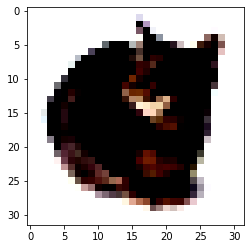

In [ ]:
# Each datapoint is a tuple with a (3,32,32) tensor and an int as label 

prng = RandomState(2)
random_permute = prng.permutation(np.arange(0, 1000))
classes =  prng.permutation(np.arange(0,10))
indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

train_data = Subset(cifar_data, indx_train)
val_data = Subset(cifar_data_val, indx_val)

print(train_data.indices.shape[0])
print(val_data.indices.shape[0])

print('\n\nBaseline Datapoint')
datapoint = train_data[82][0]
datapoint = datapoint.numpy()
datapoint = np.transpose(datapoint, (1,2,0))
plt.imshow(datapoint);

#### Horizontal Flipping

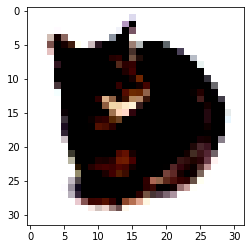

In [ ]:
# Creates a new datapoint by flipping the input image and assigning it the same label.  
def flipHorizontal(data):
  label = data[1]
  flip = torchvision.transforms.RandomHorizontalFlip(p=1.0)
  img = flip(data[0])
  datapoint = (img, label)
  return datapoint


datapoint = train_data[82]
newPoint = flipHorizontal(datapoint)

img = newPoint[0].numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img)

#### Image Rotation

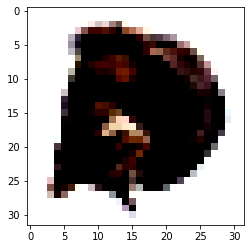

In [ ]:
# Creates a new datapoint by rotating the input by a number of degrees indicated by angle (float), and assigns it the same class label. 
def rotatePoint(data, angle):
  rotated = torchvision.transforms.functional.rotate(data[0],angle = angle)
  newPoint = (rotated, data[1])
  return newPoint

datapoint = train_data[82]
newPoint = rotatePoint(datapoint, 180.0)
img = newPoint[0].numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img)

#### Color Isolation

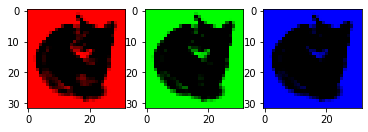

In [ ]:
# Creates 3 new datapoints by isolating each RGB channel of the input image. The same original label is assigned to each
def isolateRGB(data):
  datapointR = np.copy(data[0])
  datapointG = np.copy(data[0])
  datapointB = np.copy(data[0])
  datapointR[1] = datapointR[2] = datapointG[0] = datapointG[2] = datapointB[0] = datapointB[1] = 0
  newPoints = [(datapointR, data[1]), (datapointG, data[1]), (datapointB, data[1])]
  return newPoints

datapoint = train_data[82]
newPoints = isolateRGB(datapoint)

imgR = newPoints[0][0]
imgG = newPoints[1][0]
imgB = newPoints[2][0]

imgR = np.transpose(imgR, (1,2,0))
imgG = np.transpose(imgG, (1,2,0))
imgB = np.transpose(imgB, (1,2,0))

f, axarr = plt.subplots(1,3)
axarr[0].imshow(imgR)
axarr[1].imshow(imgG)
axarr[2].imshow(imgB)

#### PatchShuffle Regularization

https://arxiv.org/pdf/1707.07103.pdf

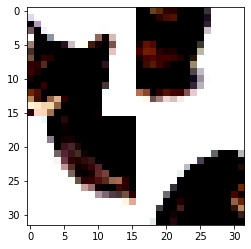

In [ ]:
import torch.nn.functional as nnf

# PatchShuffle implementation from: https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
class ShufflePatches(object):
  def __init__(self, patch_size):
    self.ps = patch_size

  def __call__(self, x):
    # divide the batch of images into non-overlapping patches
    u = nnf.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    # permute the patches of each image in the batch
    pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
    # fold the permuted patches back together
    f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    return f

# Creates new datapoint by randomly shuffling sections of the input image with size determined by the kernel. 
def PatchShuffle(data, kernel=(16,16)):
  shuffle = ShufflePatches(kernel)
  img = np.reshape(data[0], (-1,3,32,32))
  newImg = shuffle(img)
  newImg = np.reshape(newImg, (3,32,32))
  newPoint = (newImg, data[1])
  return newPoint

dataPoint = train_data[82]
newPoint = PatchShuffle(dataPoint)
img = newPoint[0]
img = np.transpose(img, (1,2,0))
plt.imshow(img)


#### Sample Pairing/Image Mixing

In [ ]:
# Creates a new image by averaging the pixel value of 2 images at each color channel. The label attached should be the same as im1. 
# Point1 and Point2 are tuples of a (3,32,32) tensor and an int representing the images label

def averageImages(point1, point2):
  generatedImg = np.empty([3,32,32])
  for i in range(3):
    layer = (point1[0][i] + point2[0][i])/2
    generatedImg[i] = layer
  generatedPoint = (generatedImg, point1[1])
  return generatedPoint

Label: 3


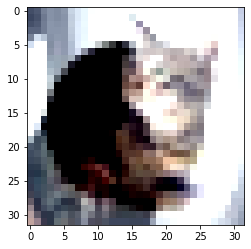

In [ ]:
datapoint = train_data[82]
datapoint2 = train_data[81]

generatedPoint = averageImages(datapoint, datapoint2)

generatedImg = generatedPoint[0]
generatedImg = np.transpose(generatedImg, (1,2,0))
plt.imshow(generatedImg)
print("Label:",generatedPoint[1])

#### Testing Augmentations

Training Definition

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*5*5, 10)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*5*5)
        x = self.fc(x)
        return x

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

###### First Augmentation Set Attempt - TESTED

In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(360600, 3, 32, 32)
allSamplesL = torch.empty(360600)

# The set currently becomes 6N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation  - 2N
    flip = flipHorizontal(sample)
    allSamples.append(flip)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

    # Second Augmentation - 5N 
    rotate90 = rotatePoint(sample, 90)
    allSamples.append(rotate90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamples.append(rotate180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamples.append(rotate270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1
    
    # Third Augmentation - 6N
    patch = PatchShuffle(sample)
    allSamples.append(patch)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1
    
print(len(allSamples))  

# Image Mixing Augmentation 
# Makes the set (6N)^2+6N
for i in range(len(allSamples)):
  point1 = allSamples[i]
  for j in range(len(allSamples)):
    point2 = allSamples[j]
    avgImg = averageImages(point1, point2)
    img, label = avgImg[0], avgImg[1]
    img = torch.from_numpy(img)
    allSamplesT[tensorIndex] = img
    allSamplesL[tensorIndex] = label
    tensorIndex += 1

allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0
shuffledSamplesT = 0
shuffledSamplesL = 0


# Makes the set 4((6N)^2 + 6N)
# for sample in allSamples:
#     # Fourth Augmentation 
#     RGB = isolateRGB(sample)
#     allSamples.append(RGB[0])
#     allSamples.append(RGB[1])
#     allSamples.append(RGB[2])


# Running into crash after RAM maxed out
  

600


Performance 1: On set of size (6N)^2+6N

In [ ]:
accs = []

# Reduced seed range here due to excessive compute
for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Num Samples For Training 360600 Num Samples For Val 700
Train Epoch: 0 [67608/360600 (100%)]	Loss: 0.334017
Train Epoch: 5 [67608/360600 (100%)]	Loss: 0.281043
Train Epoch: 10 [67608/360600 (100%)]	Loss: 0.434169
Train Epoch: 15 [67608/360600 (100%)]	Loss: 0.460172
Train Epoch: 20 [67608/360600 (100%)]	Loss: 0.169757
Train Epoch: 25 [67608/360600 (100%)]	Loss: 0.417007
Train Epoch: 30 [67608/360600 (100%)]	Loss: 0.215559
Train Epoch: 35 [67608/360600 (100%)]	Loss: 0.293782
Train Epoch: 40 [67608/360600 (100%)]	Loss: 0.324275
Train Epoch: 45 [67608/360600 (100%)]	Loss: 0.443098
Train Epoch: 50 [67608/360600 (100%)]	Loss: 0.351807
Train Epoch: 55 [67608/360600 (100%)]	Loss: 0.271874
Train Epoch: 60 [67608/360600 (100%)]	Loss: 0.400660
Train Epoch: 65 [67608/360600 (100%)]	Loss: 0.432385
Train Epoch: 70 [67608/360600 (100%)]	Loss: 0.307998
Train Epoch: 75 [67608/360600 (100%)]	Loss: 0.363038
Train Epoch: 80 [67608/360600 (100%)]	Loss: 0.374827
Train Epoch: 85 [67608/360600 (100%)]	Loss: 0

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.9283, Accuracy: 417/700 (59.57%)

Num Samples For Training 360600 Num Samples For Val 700
Train Epoch: 0 [67608/360600 (100%)]	Loss: 0.477207
Train Epoch: 5 [67608/360600 (100%)]	Loss: 0.247694
Train Epoch: 10 [67608/360600 (100%)]	Loss: 0.329753
Train Epoch: 15 [67608/360600 (100%)]	Loss: 0.294983
Train Epoch: 20 [67608/360600 (100%)]	Loss: 0.367429
Train Epoch: 25 [67608/360600 (100%)]	Loss: 0.594104
Train Epoch: 30 [67608/360600 (100%)]	Loss: 0.415422
Train Epoch: 35 [67608/360600 (100%)]	Loss: 0.420015
Train Epoch: 40 [67608/360600 (100%)]	Loss: 0.499807
Train Epoch: 45 [67608/360600 (100%)]	Loss: 0.198612
Train Epoch: 50 [67608/360600 (100%)]	Loss: 0.421486
Train Epoch: 55 [67608/360600 (100%)]	Loss: 0.324170
Train Epoch: 60 [67608/360600 (100%)]	Loss: 0.286813
Train Epoch: 65 [67608/360600 (100%)]	Loss: 0.485551
Train Epoch: 70 [67608/360600 (100%)]	Loss: 0.451019
Train Epoch: 75 [67608/360600 (100%)]	Loss: 0.349651
Train Epoch: 80 [67608/360600 (100%)]

Resulted in an average accuracy opf 57% and took 3 hours to complete. Very poor performance in comparison to the testbed. 

###### Second Augmentation Set Attempt - TESTED

Here I decide to mix images only if they have not been PatchShuffled. The intent is to reduce chaos of images and look for improved performance. 

Performance 2: On set of size 250600

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(250600, 3, 32, 32)
allSamplesL = torch.empty(250600)
#shuffledSamplesT = torch.empty(400000, 3, 32, 32)
#shuffledSamplesL = torch.empty(400000)

# The set currently becomes 5N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation 
    flip = flipHorizontal(sample)
    allSamples.append(flip)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

    # Second Augmentation
    rotate90 = rotatePoint(sample, 90)
    allSamples.append(rotate90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamples.append(rotate180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamples.append(rotate270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1

    # Third Augmentation 
    # The data created here is not passed to the image mixing step
    # Final size is ???
    patch = PatchShuffle(sample)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1
    
print(len(allSamples))  

# Image Mixing Augmentation
# Makes the set (5N)^2+6N
for i in range(len(allSamples)):
  point1 = allSamples[i]
  for j in range(len(allSamples)):
    point2 = allSamples[j]
    avgImg = averageImages(point1, point2)
    img, label = avgImg[0], avgImg[1]
    img = torch.from_numpy(img)
    allSamplesT[tensorIndex] = img
    allSamplesL[tensorIndex] = label
    tensorIndex += 1


print(tensorIndex)
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0
shuffledSamplesT = 0
shuffledSamplesL = 0

500
250600


In [ ]:
accs = []

for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Num Samples For Training 250600 Num Samples For Val 700
Train Epoch: 0 [203528/250600 (100%)]	Loss: 0.484987
Train Epoch: 5 [203528/250600 (100%)]	Loss: 0.432981
Train Epoch: 10 [203528/250600 (100%)]	Loss: 0.408245
Train Epoch: 15 [203528/250600 (100%)]	Loss: 0.435153
Train Epoch: 20 [203528/250600 (100%)]	Loss: 0.389108
Train Epoch: 25 [203528/250600 (100%)]	Loss: 0.354758
Train Epoch: 30 [203528/250600 (100%)]	Loss: 0.395042
Train Epoch: 35 [203528/250600 (100%)]	Loss: 0.420857
Train Epoch: 40 [203528/250600 (100%)]	Loss: 0.351634
Train Epoch: 45 [203528/250600 (100%)]	Loss: 0.366728
Train Epoch: 50 [203528/250600 (100%)]	Loss: 0.377671
Train Epoch: 55 [203528/250600 (100%)]	Loss: 0.456261
Train Epoch: 60 [203528/250600 (100%)]	Loss: 0.341150
Train Epoch: 65 [203528/250600 (100%)]	Loss: 0.325609
Train Epoch: 70 [203528/250600 (100%)]	Loss: 0.346958
Train Epoch: 75 [203528/250600 (100%)]	Loss: 0.421911
Train Epoch: 80 [203528/250600 (100%)]	Loss: 0.395348
Train Epoch: 85 [203528/2506

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.9879, Accuracy: 421/700 (60.14%)

Num Samples For Training 250600 Num Samples For Val 700
Train Epoch: 0 [203528/250600 (100%)]	Loss: 0.481821
Train Epoch: 5 [203528/250600 (100%)]	Loss: 0.388102
Train Epoch: 10 [203528/250600 (100%)]	Loss: 0.456845
Train Epoch: 15 [203528/250600 (100%)]	Loss: 0.375706
Train Epoch: 20 [203528/250600 (100%)]	Loss: 0.476417
Train Epoch: 25 [203528/250600 (100%)]	Loss: 0.416962
Train Epoch: 30 [203528/250600 (100%)]	Loss: 0.296291
Train Epoch: 35 [203528/250600 (100%)]	Loss: 0.404478
Train Epoch: 40 [203528/250600 (100%)]	Loss: 0.374806
Train Epoch: 45 [203528/250600 (100%)]	Loss: 0.395454
Train Epoch: 50 [203528/250600 (100%)]	Loss: 0.430250
Train Epoch: 55 [203528/250600 (100%)]	Loss: 0.404180
Train Epoch: 60 [203528/250600 (100%)]	Loss: 0.441256
Train Epoch: 65 [203528/250600 (100%)]	Loss: 0.357114
Train Epoch: 70 [203528/250600 (100%)]	Loss: 0.363584
Train Epoch: 75 [203528/250600 (100%)]	Loss: 0.378627
Train Epoch: 80 [2035

###### Augmentation Third Attempt: TESTED

In the third attempt I decide to look for performance change without Image Mixing. This is to test its effectiveness and to reduce test time on this attempt. 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


# For storing and counting num of samples
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(600, 3, 32, 32)
allSamplesL = torch.empty(600)

# The set becomes 6N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation 
    flip = flipHorizontal(sample)
    allSamples.append(flip)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

    # Second Augmentation
    rotate90 = rotatePoint(sample, 90)
    allSamples.append(rotate90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamples.append(rotate180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamples.append(rotate270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1
    
    # Third Augmentation 
    patch = PatchShuffle(sample)
    allSamples.append(patch)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1

print(len(allSamples))
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

600


Performance on Set of Size 600

In [ ]:
accs = []

for seed in range(10):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Num Samples For Training 600 Num Samples For Val 700
Train Epoch: 0 [352/600 (80%)]	Loss: 2.211313
Train Epoch: 5 [352/600 (80%)]	Loss: 0.836205
Train Epoch: 10 [352/600 (80%)]	Loss: 0.692692
Train Epoch: 15 [352/600 (80%)]	Loss: 0.685642
Train Epoch: 20 [352/600 (80%)]	Loss: 0.705069
Train Epoch: 25 [352/600 (80%)]	Loss: 0.630276
Train Epoch: 30 [352/600 (80%)]	Loss: 0.638211
Train Epoch: 35 [352/600 (80%)]	Loss: 0.655020
Train Epoch: 40 [352/600 (80%)]	Loss: 0.627447
Train Epoch: 45 [352/600 (80%)]	Loss: 0.612058
Train Epoch: 50 [352/600 (80%)]	Loss: 0.658295
Train Epoch: 55 [352/600 (80%)]	Loss: 0.545183
Train Epoch: 60 [352/600 (80%)]	Loss: 0.526525
Train Epoch: 65 [352/600 (80%)]	Loss: 0.525666
Train Epoch: 70 [352/600 (80%)]	Loss: 0.554711
Train Epoch: 75 [352/600 (80%)]	Loss: 0.440040
Train Epoch: 80 [352/600 (80%)]	Loss: 0.415106
Train Epoch: 85 [352/600 (80%)]	Loss: 0.266856
Train Epoch: 90 [352/600 (80%)]	Loss: 0.296138
Train Epoch: 95 [352/600 (80%)]	Loss: 0.230130


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.0856, Accuracy: 448/700 (64.00%)

Num Samples For Training 600 Num Samples For Val 700
Train Epoch: 0 [352/600 (80%)]	Loss: 2.188674
Train Epoch: 5 [352/600 (80%)]	Loss: 0.976589
Train Epoch: 10 [352/600 (80%)]	Loss: 0.737039
Train Epoch: 15 [352/600 (80%)]	Loss: 0.694004
Train Epoch: 20 [352/600 (80%)]	Loss: 0.692214
Train Epoch: 25 [352/600 (80%)]	Loss: 0.693035
Train Epoch: 30 [352/600 (80%)]	Loss: 0.692845
Train Epoch: 35 [352/600 (80%)]	Loss: 0.689665
Train Epoch: 40 [352/600 (80%)]	Loss: 0.692252
Train Epoch: 45 [352/600 (80%)]	Loss: 0.692041
Train Epoch: 50 [352/600 (80%)]	Loss: 0.689053
Train Epoch: 55 [352/600 (80%)]	Loss: 0.661365
Train Epoch: 60 [352/600 (80%)]	Loss: 0.620348
Train Epoch: 65 [352/600 (80%)]	Loss: 0.641612
Train Epoch: 70 [352/600 (80%)]	Loss: 0.516714
Train Epoch: 75 [352/600 (80%)]	Loss: 0.646567
Train Epoch: 80 [352/600 (80%)]	Loss: 0.526837
Train Epoch: 85 [352/600 (80%)]	Loss: 0.535274
Train Epoch: 90 [352/600 (80%)]	Loss: 0.48

###### Augmentation Fourth Attempt: TESTED

In this attempt only original samples are passed through the image mixing or PatchShuffle augmentations. Essentially trying all the augmentations but keeping them all independent. 



In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(10600, 3, 32, 32)
allSamplesL = torch.empty(10600)

# The set becomes N^2 + 6N
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation  - 2N
    flip = flipHorizontal(sample)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

    # Second Augmentation - 5N 
    rotate90 = rotatePoint(sample, 90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1
    
    # Third Augmentation - 6N
    patch = PatchShuffle(sample)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1
    
print(len(allSamples))  

# Image Mixing Augmentation 
for i in range(len(allSamples)):
  point1 = allSamples[i]
  for j in range(len(allSamples)):
    point2 = allSamples[j]
    avgImg = averageImages(point1, point2)
    img, label = avgImg[0], avgImg[1]
    img = torch.from_numpy(img)
    allSamplesT[tensorIndex] = img
    allSamplesL[tensorIndex] = label
    tensorIndex += 1

print(tensorIndex)
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

# Makes the set 4((6N)^2 + 6N)
# for sample in allSamples:
#     # Fourth Augmentation 
#     RGB = isolateRGB(sample)
#     allSamples.append(RGB[0])
#     allSamples.append(RGB[1])
#     allSamples.append(RGB[2])


100
10600


Performance on set of size N^2 + 6N

In [ ]:
accs = []

for seed in range(10):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Num Samples For Training 10600 Num Samples For Val 700
Train Epoch: 0 [8528/10600 (99%)]	Loss: 0.663527
Train Epoch: 5 [8528/10600 (99%)]	Loss: 0.463868
Train Epoch: 10 [8528/10600 (99%)]	Loss: 0.324130
Train Epoch: 15 [8528/10600 (99%)]	Loss: 0.349264
Train Epoch: 20 [8528/10600 (99%)]	Loss: 0.365799
Train Epoch: 25 [8528/10600 (99%)]	Loss: 0.381983
Train Epoch: 30 [8528/10600 (99%)]	Loss: 0.484144
Train Epoch: 35 [8528/10600 (99%)]	Loss: 0.385368
Train Epoch: 40 [8528/10600 (99%)]	Loss: 0.358300
Train Epoch: 45 [8528/10600 (99%)]	Loss: 0.395377
Train Epoch: 50 [8528/10600 (99%)]	Loss: 0.441888
Train Epoch: 55 [8528/10600 (99%)]	Loss: 0.300268
Train Epoch: 60 [8528/10600 (99%)]	Loss: 0.344399
Train Epoch: 65 [8528/10600 (99%)]	Loss: 0.331104
Train Epoch: 70 [8528/10600 (99%)]	Loss: 0.440514
Train Epoch: 75 [8528/10600 (99%)]	Loss: 0.380356
Train Epoch: 80 [8528/10600 (99%)]	Loss: 0.375819
Train Epoch: 85 [8528/10600 (99%)]	Loss: 0.339792
Train Epoch: 90 [8528/10600 (99%)]	Loss: 0.3278

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.8351, Accuracy: 454/700 (64.86%)

Num Samples For Training 10600 Num Samples For Val 700
Train Epoch: 0 [8528/10600 (99%)]	Loss: 0.692713
Train Epoch: 5 [8528/10600 (99%)]	Loss: 0.446631
Train Epoch: 10 [8528/10600 (99%)]	Loss: 0.421598
Train Epoch: 15 [8528/10600 (99%)]	Loss: 0.424688
Train Epoch: 20 [8528/10600 (99%)]	Loss: 0.365492
Train Epoch: 25 [8528/10600 (99%)]	Loss: 0.440624
Train Epoch: 30 [8528/10600 (99%)]	Loss: 0.421309
Train Epoch: 35 [8528/10600 (99%)]	Loss: 0.323700
Train Epoch: 40 [8528/10600 (99%)]	Loss: 0.390913
Train Epoch: 45 [8528/10600 (99%)]	Loss: 0.383265
Train Epoch: 50 [8528/10600 (99%)]	Loss: 0.366609
Train Epoch: 55 [8528/10600 (99%)]	Loss: 0.395695
Train Epoch: 60 [8528/10600 (99%)]	Loss: 0.365585
Train Epoch: 65 [8528/10600 (99%)]	Loss: 0.322023
Train Epoch: 70 [8528/10600 (99%)]	Loss: 0.377845
Train Epoch: 75 [8528/10600 (99%)]	Loss: 0.356799
Train Epoch: 80 [8528/10600 (99%)]	Loss: 0.364799
Train Epoch: 85 [8528/10600 (99%)]	L

###### Augmentation Fifth Attempt  (WORKING ON)

Here the same process as 5 is repeated but the RBG isolation technique is also added in on original samples. 

In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(360600, 3, 32, 32)
allSamplesL = torch.empty(360600)

# The set becomes N^2 + 9N
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesT[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation  - 2N
    flip = flipHorizontal(sample)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

    # Second Augmentation - 5N 
    rotate90 = rotatePoint(sample, 90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1
    
    # Third Augmentation - 6N
    patch = PatchShuffle(sample)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1

    # Fourth Augmentation - 9N
    RGB = isolateRGB(sample)

    allSamplesT[tensorIndex] = RGB[0][0]
    allSamplesL[tensorIndex] = RGB[0][1]
    tensorIndex += 1

    allSamplesT[tensorIndex] = RGB[1][0]
    allSamplesL[tensorIndex] = RGB[1][1]
    tensorIndex += 1

    allSamplesT[tensorIndex] = RGB[2][0]
    allSamplesL[tensorIndex] = RGB[2][1]
    tensorIndex += 1
    
print(len(allSamples))  

# Image Mixing Augmentation 
# Makes the set (6N)^2+6N
for i in range(len(allSamples)):
  point1 = allSamples[i]
  for j in range(len(allSamples)):
    point2 = allSamples[j]
    avgImg = averageImages(point1, point2)
    img, label = avgImg[0], avgImg[1]
    img = torch.from_numpy(img)
    allSamplesT[tensorIndex] = img
    allSamplesL[tensorIndex] = label
    tensorIndex += 1

print(tensorIndex)
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

# Makes the set 4((6N)^2 + 6N)
# for sample in allSamples:
#     # Fourth Augmentation 
#     RGB = isolateRGB(sample)
#     allSamples.append(RGB[0])
#     allSamples.append(RGB[1])
#     allSamples.append(RGB[2])


TypeError: ignored

###### Testing Augmentations Independently: Image Mixing - TESTED

In this attempt, I try only using Image Mixing. The idea is that the technique might be worsened by the other augmentations. It will also help to guide the question of whether data quantity matters more.  

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(10000, 3, 32, 32)
allSamplesL = torch.empty(10000)


# Result in a set of size N^2
tensorIndex = 0
# Image Mixing Augmentation 
for i in range(len(train_data)):
  point1 = train_data[i]
  for j in range(len(train_data)):
    point2 = train_data[j]
    avgImg = averageImages(point1, point2)
    img, label = avgImg[0], avgImg[1]
    img = torch.from_numpy(img)
    allSamplesT[tensorIndex] = img
    allSamplesL[tensorIndex] = label
    tensorIndex += 1


print(tensorIndex)
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

10000


Performance on set of size 10000: TESTED

In [ ]:
accs = []

for seed in range(10):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Num Samples For Training 10000 Num Samples For Val 700
Train Epoch: 0 [1248/10000 (99%)]	Loss: 0.695857
Train Epoch: 5 [1248/10000 (99%)]	Loss: 0.292536
Train Epoch: 10 [1248/10000 (99%)]	Loss: 0.373371
Train Epoch: 15 [1248/10000 (99%)]	Loss: 0.383896
Train Epoch: 20 [1248/10000 (99%)]	Loss: 0.367283
Train Epoch: 25 [1248/10000 (99%)]	Loss: 0.177316
Train Epoch: 30 [1248/10000 (99%)]	Loss: 0.253645
Train Epoch: 35 [1248/10000 (99%)]	Loss: 0.303409
Train Epoch: 40 [1248/10000 (99%)]	Loss: 0.423574
Train Epoch: 45 [1248/10000 (99%)]	Loss: 0.364522
Train Epoch: 50 [1248/10000 (99%)]	Loss: 0.330531
Train Epoch: 55 [1248/10000 (99%)]	Loss: 0.471528
Train Epoch: 60 [1248/10000 (99%)]	Loss: 0.348307
Train Epoch: 65 [1248/10000 (99%)]	Loss: 0.311509
Train Epoch: 70 [1248/10000 (99%)]	Loss: 0.455536
Train Epoch: 75 [1248/10000 (99%)]	Loss: 0.482772
Train Epoch: 80 [1248/10000 (99%)]	Loss: 0.581650
Train Epoch: 85 [1248/10000 (99%)]	Loss: 0.431359
Train Epoch: 90 [1248/10000 (99%)]	Loss: 0.2808

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.9080, Accuracy: 398/700 (56.86%)

Num Samples For Training 10000 Num Samples For Val 700
Train Epoch: 0 [1248/10000 (99%)]	Loss: 0.657208
Train Epoch: 5 [1248/10000 (99%)]	Loss: 0.421814
Train Epoch: 10 [1248/10000 (99%)]	Loss: 0.638311
Train Epoch: 15 [1248/10000 (99%)]	Loss: 0.459616
Train Epoch: 20 [1248/10000 (99%)]	Loss: 0.495959
Train Epoch: 25 [1248/10000 (99%)]	Loss: 0.347256
Train Epoch: 30 [1248/10000 (99%)]	Loss: 0.431690
Train Epoch: 35 [1248/10000 (99%)]	Loss: 0.333331
Train Epoch: 40 [1248/10000 (99%)]	Loss: 0.377229
Train Epoch: 45 [1248/10000 (99%)]	Loss: 0.429976
Train Epoch: 50 [1248/10000 (99%)]	Loss: 0.302949
Train Epoch: 55 [1248/10000 (99%)]	Loss: 0.240309
Train Epoch: 60 [1248/10000 (99%)]	Loss: 0.236269
Train Epoch: 65 [1248/10000 (99%)]	Loss: 0.232860
Train Epoch: 70 [1248/10000 (99%)]	Loss: 0.373429
Train Epoch: 75 [1248/10000 (99%)]	Loss: 0.307543
Train Epoch: 80 [1248/10000 (99%)]	Loss: 0.499006
Train Epoch: 85 [1248/10000 (99%)]	L

###### Testing Augmentations Independently: Horizontal Flip - TESTED



In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(200, 3, 32, 32)
allSamplesL = torch.empty(200)

tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # First Augmentation  - 2N
    flip = flipHorizontal(sample)
    allSamples.append(flip)
    allSamplesT[tensorIndex] = flip[0]
    allSamplesL[tensorIndex] = flip[1]
    tensorIndex += 1

allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

Performance:

In [ ]:
accs = []

# Reduced seed range here due to excessive compute
for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Num Samples For Training 200 Num Samples For Val 700
Train Epoch: 0 [72/200 (50%)]	Loss: 2.305393
Train Epoch: 5 [72/200 (50%)]	Loss: 1.228265
Train Epoch: 10 [72/200 (50%)]	Loss: 0.925695
Train Epoch: 15 [72/200 (50%)]	Loss: 0.702102
Train Epoch: 20 [72/200 (50%)]	Loss: 0.590716
Train Epoch: 25 [72/200 (50%)]	Loss: 0.566845
Train Epoch: 30 [72/200 (50%)]	Loss: 0.448774
Train Epoch: 35 [72/200 (50%)]	Loss: 0.518920
Train Epoch: 40 [72/200 (50%)]	Loss: 0.550923
Train Epoch: 45 [72/200 (50%)]	Loss: 0.503271
Train Epoch: 50 [72/200 (50%)]	Loss: 0.522410
Train Epoch: 55 [72/200 (50%)]	Loss: 0.470818
Train Epoch: 60 [72/200 (50%)]	Loss: 0.414937
Train Epoch: 65 [72/200 (50%)]	Loss: 0.401721
Train Epoch: 70 [72/200 (50%)]	Loss: 0.349051
Train Epoch: 75 [72/200 (50%)]	Loss: 0.248904
Train Epoch: 80 [72/200 (50%)]	Loss: 0.300288
Train Epoch: 85 [72/200 (50%)]	Loss: 0.320198
Train Epoch: 90 [72/200 (50%)]	Loss: 0.196312
Train Epoch: 95 [72/200 (50%)]	Loss: 0.092491

Test set: Average loss: 0.98

###### Testing Augmentations Independently: Rotation - TESTED



In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(400, 3, 32, 32)
allSamplesL = torch.empty(400)

# The set currently becomes 4N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # Second Augmentation - 5N 
    rotate90 = rotatePoint(sample, 90)
    allSamples.append(rotate90)
    allSamplesT[tensorIndex] = rotate90[0]
    allSamplesL[tensorIndex] = rotate90[1]
    tensorIndex += 1

    rotate180 = rotatePoint(sample, 180)
    allSamples.append(rotate180)
    allSamplesT[tensorIndex] = rotate180[0]
    allSamplesL[tensorIndex] = rotate180[1]
    tensorIndex += 1

    rotate270 = rotatePoint(sample, 270)
    allSamples.append(rotate270)
    allSamplesT[tensorIndex] = rotate270[0]
    allSamplesL[tensorIndex] = rotate270[1]
    tensorIndex += 1
    

allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0
  

Performance:

In [ ]:
accs = []

# Reduced seed range here due to excessive compute
for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Num Samples For Training 400 Num Samples For Val 700
Train Epoch: 0 [48/400 (75%)]	Loss: 2.258873
Train Epoch: 5 [48/400 (75%)]	Loss: 0.797519
Train Epoch: 10 [48/400 (75%)]	Loss: 0.657878
Train Epoch: 15 [48/400 (75%)]	Loss: 0.608598
Train Epoch: 20 [48/400 (75%)]	Loss: 0.611185
Train Epoch: 25 [48/400 (75%)]	Loss: 0.587426
Train Epoch: 30 [48/400 (75%)]	Loss: 0.583778
Train Epoch: 35 [48/400 (75%)]	Loss: 0.576386
Train Epoch: 40 [48/400 (75%)]	Loss: 0.692542
Train Epoch: 45 [48/400 (75%)]	Loss: 0.667150
Train Epoch: 50 [48/400 (75%)]	Loss: 0.483062
Train Epoch: 55 [48/400 (75%)]	Loss: 0.456198
Train Epoch: 60 [48/400 (75%)]	Loss: 0.425293
Train Epoch: 65 [48/400 (75%)]	Loss: 0.345842
Train Epoch: 70 [48/400 (75%)]	Loss: 0.384416
Train Epoch: 75 [48/400 (75%)]	Loss: 0.525832
Train Epoch: 80 [48/400 (75%)]	Loss: 0.177597
Train Epoch: 85 [48/400 (75%)]	Loss: 0.378766
Train Epoch: 90 [48/400 (75%)]	Loss: 0.149796
Train Epoch: 95 [48/400 (75%)]	Loss: 0.069188

Test set: Average loss: 1.41

###### Testing Augmentations Independently: PatchShuffle - TESTED




In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(200, 3, 32, 32)
allSamplesL = torch.empty(200)

# The set currently becomes 2N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamples.append(sample)
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1
    
    # Third Augmentation - 2N
    patch = PatchShuffle(sample)
    allSamples.append(patch)
    allSamplesT[tensorIndex] = patch[0]
    allSamplesL[tensorIndex] = patch[1]
    tensorIndex += 1

allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

Performance:

In [ ]:
accs = []

# Reduced seed range here due to excessive compute
for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Num Samples For Training 200 Num Samples For Val 700
Train Epoch: 0 [72/200 (50%)]	Loss: 2.271960
Train Epoch: 5 [72/200 (50%)]	Loss: 1.477528
Train Epoch: 10 [72/200 (50%)]	Loss: 3.708284
Train Epoch: 15 [72/200 (50%)]	Loss: 0.980311
Train Epoch: 20 [72/200 (50%)]	Loss: 0.702991
Train Epoch: 25 [72/200 (50%)]	Loss: 0.696860
Train Epoch: 30 [72/200 (50%)]	Loss: 0.701446
Train Epoch: 35 [72/200 (50%)]	Loss: 0.651991
Train Epoch: 40 [72/200 (50%)]	Loss: 0.669048
Train Epoch: 45 [72/200 (50%)]	Loss: 0.664618
Train Epoch: 50 [72/200 (50%)]	Loss: 0.655785
Train Epoch: 55 [72/200 (50%)]	Loss: 0.613575
Train Epoch: 60 [72/200 (50%)]	Loss: 0.610391
Train Epoch: 65 [72/200 (50%)]	Loss: 0.578833
Train Epoch: 70 [72/200 (50%)]	Loss: 0.540518
Train Epoch: 75 [72/200 (50%)]	Loss: 0.543510
Train Epoch: 80 [72/200 (50%)]	Loss: 0.512203
Train Epoch: 85 [72/200 (50%)]	Loss: 0.410833
Train Epoch: 90 [72/200 (50%)]	Loss: 0.476515
Train Epoch: 95 [72/200 (50%)]	Loss: 0.442851

Test set: Average loss: 0.87

###### Testing Augmentations Independently: Color Isolation - TESTED



In [ ]:
# Augmenting Training Set
from torch.utils.data import TensorDataset, DataLoader

# For storing the samples and generated samples in between steps
allSamples = []

# ------>  Size of tensor would need to change for different input sizes (here assumes 100)
allSamplesT = torch.empty(400, 3, 32, 32)
allSamplesL = torch.empty(400)

# The set currently becomes 6N where N is 100
tensorIndex = 0
for sample in train_data:
    # Appending the original samples - N
    allSamplesT[tensorIndex] = sample[0]
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1

    # Fourth Augmentation 
    RGB = isolateRGB(sample)
    allSamples.append(RGB[0])
    allSamples.append(RGB[1])
    allSamples.append(RGB[2])

for sample in allSamples:
    allSamplesT[tensorIndex] = torch.from_numpy(sample[0])
    allSamplesL[tensorIndex] = sample[1]
    tensorIndex += 1
   

print(tensorIndex)
allSamples = TensorDataset(allSamplesT, allSamplesL)

# Free memory
allSamplesT = 0
allSamplesL = 0

400


Performance:

In [ ]:
accs = []

# Reduced seed range here due to excessive compute
for seed in range(5):
  print('Num Samples For Training %d Num Samples For Val %d'%(tensorIndex,val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(allSamples,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Num Samples For Training 400 Num Samples For Val 700
Train Epoch: 0 [48/400 (75%)]	Loss: 2.219952
Train Epoch: 5 [48/400 (75%)]	Loss: 0.774265
Train Epoch: 10 [48/400 (75%)]	Loss: 0.681632
Train Epoch: 15 [48/400 (75%)]	Loss: 0.739388
Train Epoch: 20 [48/400 (75%)]	Loss: 0.550577
Train Epoch: 25 [48/400 (75%)]	Loss: 0.656374
Train Epoch: 30 [48/400 (75%)]	Loss: 0.616016
Train Epoch: 35 [48/400 (75%)]	Loss: 0.513901
Train Epoch: 40 [48/400 (75%)]	Loss: 0.313403
Train Epoch: 45 [48/400 (75%)]	Loss: 0.513899
Train Epoch: 50 [48/400 (75%)]	Loss: 0.367290
Train Epoch: 55 [48/400 (75%)]	Loss: 0.252869
Train Epoch: 60 [48/400 (75%)]	Loss: 0.105109
Train Epoch: 65 [48/400 (75%)]	Loss: 0.403444
Train Epoch: 70 [48/400 (75%)]	Loss: 0.032661
Train Epoch: 75 [48/400 (75%)]	Loss: 0.005320
Train Epoch: 80 [48/400 (75%)]	Loss: 0.010663
Train Epoch: 85 [48/400 (75%)]	Loss: 0.026192
Train Epoch: 90 [48/400 (75%)]	Loss: 0.034583
Train Epoch: 95 [48/400 (75%)]	Loss: 0.330638


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.0438, Accuracy: 402/700 (57.43%)

Num Samples For Training 400 Num Samples For Val 700
Train Epoch: 0 [48/400 (75%)]	Loss: 2.249136
Train Epoch: 5 [48/400 (75%)]	Loss: 0.658873
Train Epoch: 10 [48/400 (75%)]	Loss: 0.625060
Train Epoch: 15 [48/400 (75%)]	Loss: 0.671216
Train Epoch: 20 [48/400 (75%)]	Loss: 0.837758
Train Epoch: 25 [48/400 (75%)]	Loss: 0.690276
Train Epoch: 30 [48/400 (75%)]	Loss: 0.749813
Train Epoch: 35 [48/400 (75%)]	Loss: 0.567002
Train Epoch: 40 [48/400 (75%)]	Loss: 0.614080
Train Epoch: 45 [48/400 (75%)]	Loss: 0.450116
Train Epoch: 50 [48/400 (75%)]	Loss: 0.474037
Train Epoch: 55 [48/400 (75%)]	Loss: 0.438748
Train Epoch: 60 [48/400 (75%)]	Loss: 0.208759
Train Epoch: 65 [48/400 (75%)]	Loss: 0.152993
Train Epoch: 70 [48/400 (75%)]	Loss: 0.061572
Train Epoch: 75 [48/400 (75%)]	Loss: 0.076897
Train Epoch: 80 [48/400 (75%)]	Loss: 0.073512
Train Epoch: 85 [48/400 (75%)]	Loss: 0.031268
Train Epoch: 90 [48/400 (75%)]	Loss: 0.003571
Train Epoch: 9

### Method 2 Synthetic Data

Imports

In [ ]:
# example of a dcgan on cifar10
import torch
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

DATA SPLIT

In [ ]:
  # Loading data
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()
  # Value normalization
  X_train  = X_train/255
  X_test  = X_test/255

  #extract indexes of 2 classes (0 and 1 in his case)
  classes_indx=[]
  for i in range(len(y_train)):
    if y_train[i][0]==0 or y_train[i][0]==1:
      temp=[]
      temp.append(i)
      classes_indx.append(temp)

  classes_indx_test=[]
  for i in range(len(y_test)):
    if y_test[i][0]==0 or y_test[i][0]==1:
      temp=[]
      temp.append(i)
      classes_indx_test.append(temp)

  #pick only 2 classes for train and test
  X_train_2classes=[]
  for i in classes_indx:
    X_train_2classes.append(X_train[i[0]])

  y_train_2classes=[]
  for i in classes_indx:
    y_train_2classes.append(y_train[i[0]])

  X_test_2classes=[]
  for i in classes_indx_test:
    X_test_2classes.append(X_test[i[0]])

  y_test_2classes=[]
  for i in classes_indx_test:
    y_test_2classes.append(y_test[i[0]])

  #pick 100 samples
  X_train_2classes_100 = X_train_2classes[:100]
  y_train_2classes_100 = y_train_2classes[:100]

  X_test_2classes_100 = X_train_2classes[101:801]
  y_test_2classes_100 = y_train_2classes[101:801]

  #lists to np arrays
  X_train_2classes_100 = np.asarray(X_train_2classes_100)
  y_train_2classes_100 = np.asarray(y_train_2classes_100)

  X_test_2classes_700 = np.asarray(X_test_2classes_100)
  y_test_2classes_700 = np.asarray(y_test_2classes_100)

Function to get 50 samples of target class. Receives integer from 0-9, return 50 samples of the appropriate CIFAR10 calss

In [ ]:
def custom_train_dataset(target_class):
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()
  #extract indexes of 2 classes (0 and 1 in his case)
  classes_indx=[]
  for i in range(len(y_train)):
    if y_train[i][0]==target_class:
      temp=[]
      temp.append(i)
      classes_indx.append(temp)


  #pick only 1 classes for train and test
  X_train_target_class=[]
  for i in classes_indx:
    X_train_target_class.append(X_train[i[0]])

  #pick 50 samples
  X_train_target_class_50 = X_train_target_class[:50]
  #lists to np arrays
  X_train_target_class_50 = np.asarray(X_train_target_class_50)
  return X_train_target_class_50

GENERATOR AND DISCRIMINATOR DEFINITION FOR SYNTHETIC DATA CREATION (**CLASS 1**) USING TRAINED MODEL. THE MODEL TRAINED ONLY ON 50 SAPLES/2CLASSES AS PER REQUIREMENTS

In [ ]:
def custom_train_dataset(target_class):
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()
  #extract indexes of 2 classes (0 and 1 in his case)
  classes_indx=[]
  for i in range(len(y_train)):
    if y_train[i][0]==target_class:
      temp=[]
      temp.append(i)
      classes_indx.append(temp)


  #pick only 1 classes for train and test
  X_train_target_class=[]
  for i in classes_indx:
    X_train_target_class.append(X_train[i[0]])

  #pick 50 samples
  X_train_target_class_50 = X_train_target_class[:50]
  #lists to np arrays
  X_train_target_class_50 = np.asarray(X_train_target_class_50)
  return X_train_target_class_50

In [ ]:
from keras.datasets import cifar10
import numpy as np

def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
 
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
 	
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile the model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


def load_real_samples():
	
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
 
	trainX = custom_train_dataset(0)
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return X


def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y


def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	#  fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

#  generator and discriminator training
def train(g_model, device, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=2): 
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
latent_dim = 1000
# create the discriminator
d_model = define_discriminator()

# generator
g_model = define_generator(latent_dim)
# gan
gan_model = define_gan(g_model, d_model)
# image data
dataset = load_real_samples()
# train model
train(g_model,device, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 9ms/step


5/5 [==============================] - 0s 10ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


32/32 [==============================] - 0s 6ms/step


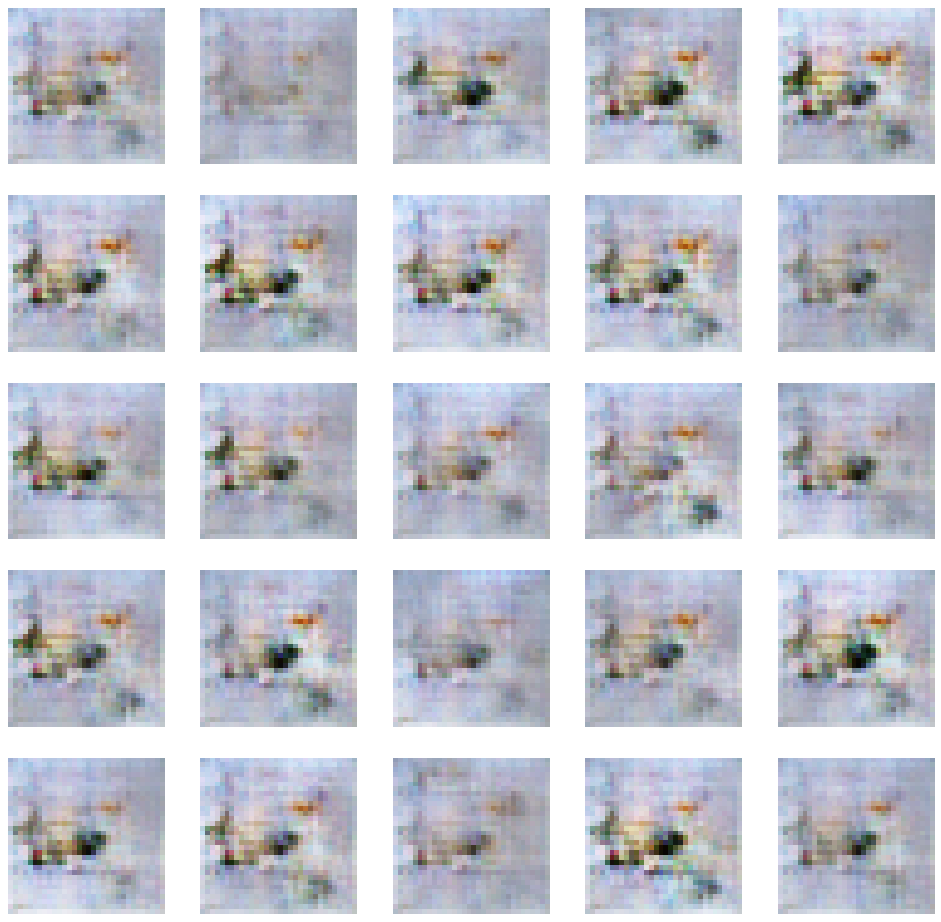

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
    
		pyplot.imshow(examples[i, :, :])
  
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(1000, 1000)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.figure(figsize=(15, 15), dpi=80)
create_plot(X, 5)

GENERATOR AND DISCRIMINATOR DEFINITION FOR SYNTHETIC DATA CREATION (**CLASS 2**) USING TRAINED MODEL. THE MODEL TRAINED ONLY ON 50 SAPLES/2CLASSES AS PER REQUIREMENTS

In [ ]:
from keras.datasets import cifar10
import numpy as np

def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
 	
	#  generator
	model.add(g_model)
	# discriminator
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


def load_real_samples():
	(trainX, _), (_, _) = load_data()
 
	trainX = custom_train_dataset(1)
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=200):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, device, d_model, gan_model, dataset, latent_dim, n_epochs=150, n_batch=2): #!!!!!!!!!!!!!!!!!!!!!!!!!
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)



# latent space
latent_dim = 1000
# discriminator
d_model = define_discriminator()

#  generator
g_model = define_generator(latent_dim)
# gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model,device, d_model, gan_model, dataset, latent_dim)

5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 7ms/step


5/5 [==============================] - 0s 7ms/step


GENERATE 1000 SAMPLES  OF CLASS 2

32/32 [==============================] - 0s 6ms/step


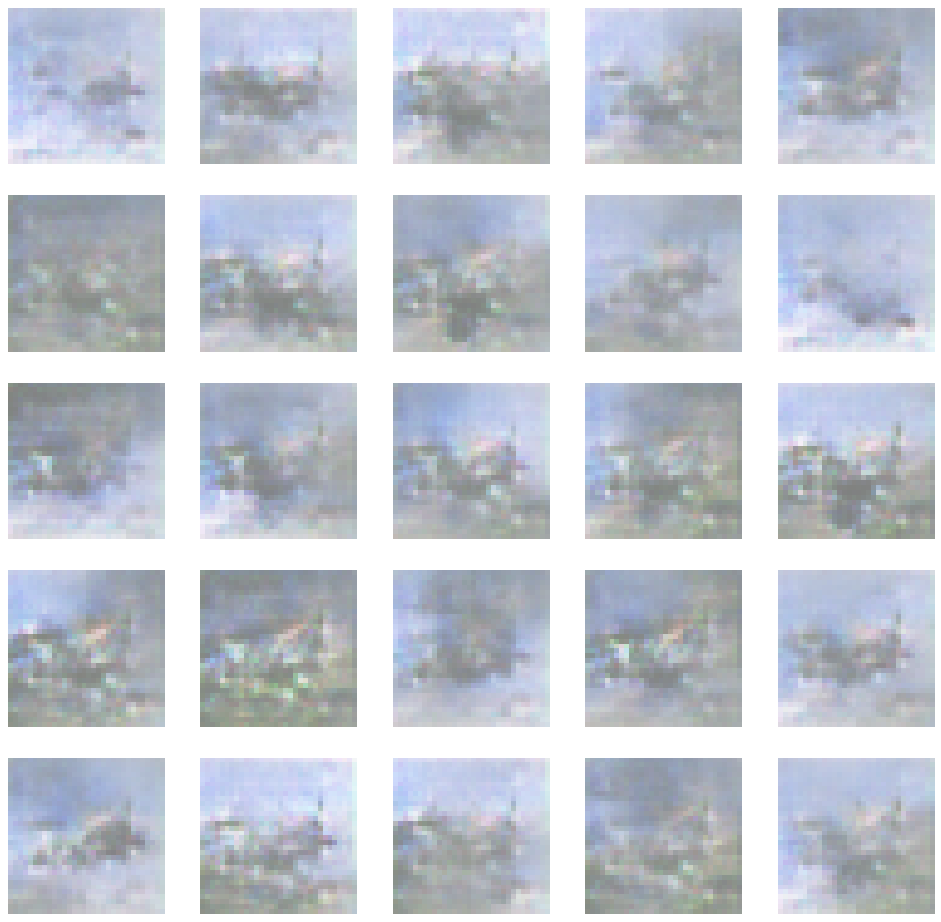

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
    
		pyplot.imshow(examples[i, :, :])
  
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(1000, 1000)
# generate images
X1 = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X1 = (X + 1) / 2.0
# plot the result
pyplot.figure(figsize=(15, 15), dpi=80)
create_plot(X1, 5)

DATA ASSEMBLING TO TRAIN AND EVALUATE

In [ ]:
#prepare custom training set
total_X_train_2classes=[]
class1=custom_train_dataset(0)
class2=custom_train_dataset(1)

#append real images of class1
total_X_train_2classes.append(class1)
[total_X_train_2classes] = total_X_train_2classes

#normalize and append synthetic data of class1
X=X*255
X=X.astype('uint8')
total_X_train_2classes = np.concatenate((total_X_train_2classes,X), axis=0)


#append real images of class2
total_X_train_2classes = np.concatenate((total_X_train_2classes,class2), axis=0)

#normalize and append synthetic data of class2
X1=X1*255
X1=X1.astype('uint8')
total_X_train_2classes = np.concatenate((total_X_train_2classes,X1), axis=0)

#prepare labels set
y_train_2classes = np.zeros((2100, 1),dtype=int)

for i in range(len(y_train_2classes)):
  if i<1050:
    y_train_2classes[i][0]=0
  else:
    y_train_2classes[i][0]=1


TEST AND EVALUATION ON ONLY 50 SAMPLES FROM EACH CLASS. TOTAL: 100 TRAINING SAMPLES, 700 EVAL SAMPLES

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
accs = []
for seed in range(50):
  cnn = keras.Sequential([
      layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
      layers.MaxPooling2D((2, 2)),
      
      layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  opt = SGD(lr=0.01, momentum=0.9)
  cnn.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  cnn.fit(X_train_2classes_100, y_train_2classes_100, epochs=30)
  res=cnn.evaluate(X_test_2classes_700,y_test_2classes_700)
  accs.append(res[1])

Epoch 1/30
4/4 [==============================] - 0s 5ms/step - loss: 2.1727 - accuracy: 0.2400
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 1.3510 - accuracy: 0.5800
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 0.7352 - accuracy: 0.4800
Epoch 4/30
4/4 [==============================] - 0s 4ms/step - loss: 2.2431 - accuracy: 0.5200
Epoch 5/30
4/4 [==============================] - 0s 4ms/step - loss: 0.9322 - accuracy: 0.6000
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 1.1378 - accuracy: 0.4200
Epoch 7/30
4/4 [==============================] - 0s 4ms/step - loss: 0.9670 - accuracy: 0.4200
Epoch 8/30
4/4 [==============================] - 0s 4ms/step - loss: 0.7462 - accuracy: 0.4800
Epoch 9/30
4/4 [==============================] - 0s 4ms/step - loss: 0.7530 - accuracy: 0.5800
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.6300
Epoch 11/30
4/4 [======================

In [ ]:
accs = np.array(accs)
print('Acc over 50 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Acc over 50 instances: 0.68 +- 0.09


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
accs = []
for seed in range(50):
  cnn = keras.Sequential([
      layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
      layers.MaxPooling2D((2, 2)),
      
      layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])

  opt = SGD(lr=0.01, momentum=0.9)
  cnn.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  cnn.fit(total_X_train_2classes, y_train_2classes, epochs=30)
  res=cnn.evaluate(X_test_2classes_700,y_test_2classes_700)
  accs.append(res[1])

Epoch 1/30
66/66 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.4957
Epoch 2/30
66/66 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5000
Epoch 3/30
66/66 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5000
Epoch 4/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 5/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 6/30
66/66 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5000
Epoch 7/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 8/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 9/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 10/30
66/66 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5000
Epoch 11/30
66/66 [==============================

In [ ]:
accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Acc over 10 instances: 0.52 +- 0.03


EXAMPLE OF GOOD SYNTHETIC DATA GENERATING (USING ALL 50 000 CIFAR IMAGES)

4/4 [==============================] - 0s 7ms/step


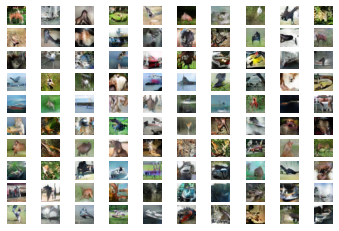

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

### Method 3

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # MODEL WITH MODIFIED KERNEL SIZE + BATCHNORM
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=5, stride=2), 
                      nn.BatchNorm2d(16),
                      nn.ReLU()]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=5), 
                      nn.BatchNorm2d(32),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                        nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 32)
        
        self.layerout=nn.Linear(32,10)



        # add one hidden layer with non linearity in the Fully Connected layers
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        rel=torch.nn.ReLU()
        x = self.fc(x)
        x=rel(x)
        x=self.layerout(x)
        
        return x



class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        # MODEL WITH BASELINE KERNEL SIZE + BATCHNORM
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.BatchNorm2d(16),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.BatchNorm2d(32),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*5*5, 32)
        
        self.layerout=nn.Linear(32,10)


        # add one hidden layer with non linearity in the Fully Connected layers
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*5*5)
        rel=torch.nn.ReLU()
        x = self.fc(x)
        x=rel(x)
        x=self.layerout(x)
        
        return x

 Learning Rate Search (Among lr=[0.1,0.01,0.008,0.001])

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 50 samples per class

accs = []

lrs,lr_accs=([0.1,0.01,0.008,0.001],[])

for tlr in lrs:
  accs = []
  for seed in range(30,40):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    print()
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])


    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data_val, indx_val)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=128, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=128, 
                                            shuffle=False)
    

    model = Net()
    model.to(device)
    
    # slightly reduce learning rate
    # lrs=[0.1,0.01,0.008,0.005]
    # lr_acs=[]
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=tlr, momentum=0.9,
                                weight_decay=0.0005)
                                
    for epoch in range(100):
      train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
      
    accs.append(test(model, device, val_loader))
    
  
  adata=  np.array(accs)
  res=([adata.mean(),adata.std()])
  lr_accs.append(res)
  
  # print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
c=0
for r in lr_accs:
  print('Learning Rate ('+str(lrs[c])+'): '+str(r))
  print('\n')
  c+=1




Files already downloaded and verified
Files already downloaded and verified

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.374567
Train Epoch: 5 [0/100 (0%)]	Loss: 22.781084
Train Epoch: 10 [0/100 (0%)]	Loss: 1.429636
Train Epoch: 15 [0/100 (0%)]	Loss: 0.883973
Train Epoch: 20 [0/100 (0%)]	Loss: 0.710661
Train Epoch: 25 [0/100 (0%)]	Loss: 0.597462
Train Epoch: 30 [0/100 (0%)]	Loss: 0.462121
Train Epoch: 35 [0/100 (0%)]	Loss: 0.334390
Train Epoch: 40 [0/100 (0%)]	Loss: 0.231649
Train Epoch: 45 [0/100 (0%)]	Loss: 0.131401
Train Epoch: 50 [0/100 (0%)]	Loss: 0.051381
Train Epoch: 55 [0/100 (0%)]	Loss: 0.009787
Train Epoch: 60 [0/100 (0%)]	Loss: 0.002027
Train Epoch: 65 [0/100 (0%)]	Loss: 0.000956
Train Epoch: 70 [0/100 (0%)]	Loss: 0.000542
Train Epoch: 75 [0/100 (0%)]	Loss: 0.000274
Train Epoch: 80 [0/100 (0%)]	Loss: 0.000184
Train Epoch: 85 [0/100 (0%)]	Loss: 0.000137
Train Epoch: 90 [0/100 (0%)]	Loss: 0.000114
Train Epoch: 95 [0/100 (0%)]	Loss: 

Testing accuracy using TestBed after modifying model, learning rates

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 50 samples per class

accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.008, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.379151
Train Epoch: 5 [0/100 (0%)]	Loss: 2.160531
Train Epoch: 10 [0/100 (0%)]	Loss: 1.180120
Train Epoch: 15 [0/100 (0%)]	Loss: 0.636040
Train Epoch: 20 [0/100 (0%)]	Loss: 0.515437
Train Epoch: 25 [0/100 (0%)]	Loss: 0.351547
Train Epoch: 30 [0/100 (0%)]	Loss: 0.226638
Train Epoch: 35 [0/100 (0%)]	Loss: 0.134627
Train Epoch: 40 [0/100 (0%)]	Loss: 0.059152
Train Epoch: 45 [0/100 (0%)]	Loss: 0.027568
Train Epoch: 50 [0/100 (0%)]	Loss: 0.011901
Train Epoch: 55 [0/100 (0%)]	Loss: 0.006052
Train Epoch: 60 [0/100 (0%)]	Loss: 0.003523
Train Epoch: 65 [0/100 (0%)]	Loss: 0.002278
Train Epoch: 70 [0/100 (0%)]	Loss: 0.001704
Train Epoch: 75 [0/100 (0%)]	Loss: 0.001339
Train Epoch: 80 [0/100 (0%)]	Loss: 0.001110
Train Epoch: 85 [0/100 (0%)]	Loss: 0.000984
Train Epoch: 90 [0/100 (0%)]	Loss: 0.000886
Train Epoch: 95 [0/100 (0%)]	Loss: 0.

Testing accuracy using TestBed after modifying model, learning rates

 TEST ON OLD VS NEW CONV LAYERS

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 50 samples per class

accs = []
a2=[]

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net()
  model.to(device)
  m2 = Net2()
  m2.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.008, momentum=0.9,
                              weight_decay=0.0005)
  o2 = torch.optim.SGD(m2.parameters(), 
  lr=0.008, momentum=0.9,
  weight_decay=0.0005)

  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    train(m2, device, train_loader, o2, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))
  a2.append(test(m2, device, val_loader))
accs = np.array(accs)
a2 = np.array(a2)
print('Acc over 10 instances with modified Conv kernels: %.2f +- %.2f'%(accs.mean(),accs.std()))
print('Acc over 10 instances with baseline kernels: %.2f +- %.2f'%(a2.mean(),a2.std()))

Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.236798
Train Epoch: 0 [0/100 (0%)]	Loss: 2.409307
Train Epoch: 5 [0/100 (0%)]	Loss: 2.110986
Train Epoch: 5 [0/100 (0%)]	Loss: 2.046768
Train Epoch: 10 [0/100 (0%)]	Loss: 1.738859
Train Epoch: 10 [0/100 (0%)]	Loss: 0.765150
Train Epoch: 15 [0/100 (0%)]	Loss: 0.807651
Train Epoch: 15 [0/100 (0%)]	Loss: 0.561233
Train Epoch: 20 [0/100 (0%)]	Loss: 0.506503
Train Epoch: 20 [0/100 (0%)]	Loss: 0.440669
Train Epoch: 25 [0/100 (0%)]	Loss: 0.386448
Train Epoch: 25 [0/100 (0%)]	Loss: 1.047794
Train Epoch: 30 [0/100 (0%)]	Loss: 0.234300
Train Epoch: 30 [0/100 (0%)]	Loss: 0.249730
Train Epoch: 35 [0/100 (0%)]	Loss: 0.117565
Train Epoch: 35 [0/100 (0%)]	Loss: 0.191163
Train Epoch: 40 [0/100 (0%)]	Loss: 0.058993
Train Epoch: 40 [0/100 (0%)]	Loss: 0.142328
Train Epoch: 45 [0/100 (0%)]	Loss: 0.024927
Train Epoch: 45 [0/100 (0%)]	Loss: 0.06

c:\Users\LAP\Anaconda\envs\GPUSTUFF\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4159, Accuracy: 625/700 (89.29%)


Test set: Average loss: 0.6261, Accuracy: 605/700 (86.43%)

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.209604
Train Epoch: 0 [0/100 (0%)]	Loss: 2.498983
Train Epoch: 5 [0/100 (0%)]	Loss: 2.033279
Train Epoch: 5 [0/100 (0%)]	Loss: 2.197569
Train Epoch: 10 [0/100 (0%)]	Loss: 1.387478
Train Epoch: 10 [0/100 (0%)]	Loss: 1.567745
Train Epoch: 15 [0/100 (0%)]	Loss: 0.610108
Train Epoch: 15 [0/100 (0%)]	Loss: 0.669258
Train Epoch: 20 [0/100 (0%)]	Loss: 0.503843
Train Epoch: 20 [0/100 (0%)]	Loss: 0.638097
Train Epoch: 25 [0/100 (0%)]	Loss: 0.402594
Train Epoch: 25 [0/100 (0%)]	Loss: 0.622127
Train Epoch: 30 [0/100 (0%)]	Loss: 0.267989
Train Epoch: 30 [0/100 (0%)]	Loss: 0.513728
Train Epoch: 35 [0/100 (0%)]	Loss: 0.152269
Train Epoch: 35 [0/100 (0%)]	Loss: 0.381179
Train Epoch: 40 [0/100 (0%)]	Loss: 0.065150
Train Epoch: 40 [0/100 (0%)]	Loss: 0.275414
Train Epoch: 45 [0/100 (0%)]	Loss: 0.

## Task 2

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

### Method 1

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        # print(' grad ::',model.conv1.weight.grad)


        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

Using the ResNet18 Model with finetuning the Fully Connected layers, without BatchNorm

This model was tested on CIFAR-10 in the paper below. Initially wanted to use the 101-layer version but ran out of CUDA memory. 
Source: https://arxiv.org/pdf/1512.03385.pdf

In [ ]:

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F
import time as timer
  
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(256) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class
start=timer.time()
accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=10, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=10, 
                                           shuffle=False)
  

  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


  model.fc = nn.Sequential(nn.Linear(512,3),nn.Sigmoid(),nn.Linear(3,  10))
  optimizer = torch.optim.SGD(model.fc.parameters(), momentum=0.9,
                              lr=0.006, weight_decay=0.0005)
  model.to(device)

  # print(model)
  # print(modelll)
  for epoch in range(10):
    train(model, device, train_loader, optimizer, epoch, display=True)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
print('TIME TAKEN (FINETUNE RESNET FC LAYERS W/OUT BATCHNORM): ',str(timer.time()-start))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.144550
Train Epoch: 1 [90/100 (90%)]	Loss: 1.796397
Train Epoch: 2 [90/100 (90%)]	Loss: 1.575010
Train Epoch: 3 [90/100 (90%)]	Loss: 1.268290
Train Epoch: 4 [90/100 (90%)]	Loss: 1.159066
Train Epoch: 5 [90/100 (90%)]	Loss: 1.067854
Train Epoch: 6 [90/100 (90%)]	Loss: 0.981698
Train Epoch: 7 [90/100 (90%)]	Loss: 0.934756
Train Epoch: 8 [90/100 (90%)]	Loss: 0.897287
Train Epoch: 9 [90/100 (90%)]	Loss: 0.882161

Test set: Average loss: 0.8670, Accuracy: 350/700 (50.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.040960
Train Epoch: 1 [90/100 (90%)]	Loss: 1.702590
Train Epoch: 2 [90/100 (90%)]	Loss: 1.316683
Train Epoch: 3 [90/100 (90%)]	Loss: 1.133116
Train Epoch: 4 [90/100 (90%)]	Loss: 0.986784
Train Epoch: 5 [90/100 (90%)]	Loss: 0.904906
Train Epoch: 6 [90/100 (90%)]	Loss: 0.851504
Train Epoch: 7 [90/100 (90%)]	Loss: 0.827385
Train Epoch: 8 [90/100 (90%)]	Loss: 0.807518
Train Epoch: 9 [90/100 (90%)]	Loss: 0.792507

Test set: Average loss: 0.7912, Accuracy: 549/700 (78.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.703543
Train Epoch: 1 [90/100 (90%)]	Loss: 1.324178
Train Epoch: 2 [90/100 (90%)]	Loss: 1.078638
Train Epoch: 3 [90/100 (90%)]	Loss: 0.907855
Train Epoch: 4 [90/100 (90%)]	Loss: 0.816136
Train Epoch: 5 [90/100 (90%)]	Loss: 0.792129
Train Epoch: 6 [90/100 (90%)]	Loss: 0.586964
Train Epoch: 7 [90/100 (90%)]	Loss: 0.671024
Train Epoch: 8 [90/100 (90%)]	Loss: 0.616363
Train Epoch: 9 [90/100 (90%)]	Loss: 0.830805

Test set: Average loss: 0.5875, Accuracy: 598/700 (85.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.572083
Train Epoch: 1 [90/100 (90%)]	Loss: 2.193778
Train Epoch: 2 [90/100 (90%)]	Loss: 1.732687
Train Epoch: 3 [90/100 (90%)]	Loss: 1.328326
Train Epoch: 4 [90/100 (90%)]	Loss: 1.099003
Train Epoch: 5 [90/100 (90%)]	Loss: 0.913894
Train Epoch: 6 [90/100 (90%)]	Loss: 0.832383
Train Epoch: 7 [90/100 (90%)]	Loss: 0.737020
Train Epoch: 8 [90/100 (90%)]	Loss: 0.681305
Train Epoch: 9 [90/100 (90%)]	Loss: 0.651147

Test set: Average loss: 0.6391, Accuracy: 663/700 (94.71%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.523216
Train Epoch: 1 [90/100 (90%)]	Loss: 2.186726
Train Epoch: 2 [90/100 (90%)]	Loss: 1.787046
Train Epoch: 3 [90/100 (90%)]	Loss: 1.472840
Train Epoch: 4 [90/100 (90%)]	Loss: 1.272548
Train Epoch: 5 [90/100 (90%)]	Loss: 1.125171
Train Epoch: 6 [90/100 (90%)]	Loss: 1.025828
Train Epoch: 7 [90/100 (90%)]	Loss: 0.969123
Train Epoch: 8 [90/100 (90%)]	Loss: 0.918659
Train Epoch: 9 [90/100 (90%)]	Loss: 0.877027

Test set: Average loss: 0.8777, Accuracy: 520/700 (74.29%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.209886
Train Epoch: 1 [90/100 (90%)]	Loss: 1.826594
Train Epoch: 2 [90/100 (90%)]	Loss: 1.532461
Train Epoch: 3 [90/100 (90%)]	Loss: 1.328194
Train Epoch: 4 [90/100 (90%)]	Loss: 1.162123
Train Epoch: 5 [90/100 (90%)]	Loss: 1.056976
Train Epoch: 6 [90/100 (90%)]	Loss: 0.984833
Train Epoch: 7 [90/100 (90%)]	Loss: 0.934596
Train Epoch: 8 [90/100 (90%)]	Loss: 0.899875
Train Epoch: 9 [90/100 (90%)]	Loss: 0.879265

Test set: Average loss: 0.8698, Accuracy: 350/700 (50.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.102304
Train Epoch: 1 [90/100 (90%)]	Loss: 1.942674
Train Epoch: 2 [90/100 (90%)]	Loss: 1.709383
Train Epoch: 3 [90/100 (90%)]	Loss: 1.464091
Train Epoch: 4 [90/100 (90%)]	Loss: 1.269719
Train Epoch: 5 [90/100 (90%)]	Loss: 1.128968
Train Epoch: 6 [90/100 (90%)]	Loss: 1.037004
Train Epoch: 7 [90/100 (90%)]	Loss: 0.975867
Train Epoch: 8 [90/100 (90%)]	Loss: 0.925349
Train Epoch: 9 [90/100 (90%)]	Loss: 0.891967

Test set: Average loss: 0.8891, Accuracy: 412/700 (58.86%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.237269
Train Epoch: 1 [90/100 (90%)]	Loss: 1.812551
Train Epoch: 2 [90/100 (90%)]	Loss: 1.456779
Train Epoch: 3 [90/100 (90%)]	Loss: 1.154108
Train Epoch: 4 [90/100 (90%)]	Loss: 1.003756
Train Epoch: 5 [90/100 (90%)]	Loss: 0.921844
Train Epoch: 6 [90/100 (90%)]	Loss: 0.869042
Train Epoch: 7 [90/100 (90%)]	Loss: 0.847635
Train Epoch: 8 [90/100 (90%)]	Loss: 0.815503
Train Epoch: 9 [90/100 (90%)]	Loss: 0.799793

Test set: Average loss: 0.7986, Accuracy: 350/700 (50.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 2.289509
Train Epoch: 1 [90/100 (90%)]	Loss: 1.697676
Train Epoch: 2 [90/100 (90%)]	Loss: 1.232235
Train Epoch: 3 [90/100 (90%)]	Loss: 0.999056
Train Epoch: 4 [90/100 (90%)]	Loss: 0.906472
Train Epoch: 5 [90/100 (90%)]	Loss: 0.835875
Train Epoch: 6 [90/100 (90%)]	Loss: 0.808431
Train Epoch: 7 [90/100 (90%)]	Loss: 0.787287
Train Epoch: 8 [90/100 (90%)]	Loss: 0.779997
Train Epoch: 9 [90/100 (90%)]	Loss: 0.764741

Test set: Average loss: 0.7639, Accuracy: 350/700 (50.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.864264
Train Epoch: 1 [90/100 (90%)]	Loss: 1.856308
Train Epoch: 2 [90/100 (90%)]	Loss: 1.454321
Train Epoch: 3 [90/100 (90%)]	Loss: 1.251884
Train Epoch: 4 [90/100 (90%)]	Loss: 1.296066
Train Epoch: 5 [90/100 (90%)]	Loss: 1.343565
Train Epoch: 6 [90/100 (90%)]	Loss: 1.042205
Train Epoch: 7 [90/100 (90%)]	Loss: 0.973855
Train Epoch: 8 [90/100 (90%)]	Loss: 0.810674
Train Epoch: 9 [90/100 (90%)]	Loss: 0.783905

Test set: Average loss: 0.8469, Accuracy: 554/700 (79.14%)

Acc over 10 instances: 67.09 +- 16.31
TIME TAKEN (FINETUNE RESNET FC LAYERS W/OUT BATCHNORM):  78.22159886360168


SAME FULLY CONNECTED MODIFICATIONS WITH BATCHNORM

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F
import time as timer
  
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(256) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class
start=timer.time()
accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=10, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=10, 
                                           shuffle=False)
  

  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

  model.fc = nn.Sequential(nn.Linear(512,3),nn.BatchNorm1d(3),nn.Sigmoid(),nn.Linear(3,  10))

  optimizer = torch.optim.SGD(model.fc.parameters(), momentum=0.9,
                              lr=0.1, weight_decay=0.0005)
  model.to(device)

 
  for epoch in range(10):
    train(model, device, train_loader, optimizer, epoch, display=True)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
print('TIME TAKEN (FINETUNE RESNET FC LAYERS W/BATCHNORM): ',str(timer.time()-start))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.003268
Train Epoch: 1 [90/100 (90%)]	Loss: 0.301448
Train Epoch: 2 [90/100 (90%)]	Loss: 0.157399
Train Epoch: 3 [90/100 (90%)]	Loss: 0.176280
Train Epoch: 4 [90/100 (90%)]	Loss: 0.561086
Train Epoch: 5 [90/100 (90%)]	Loss: 0.091566
Train Epoch: 6 [90/100 (90%)]	Loss: 0.010576
Train Epoch: 7 [90/100 (90%)]	Loss: 0.150219
Train Epoch: 8 [90/100 (90%)]	Loss: 0.020494
Train Epoch: 9 [90/100 (90%)]	Loss: 0.023850

Test set: Average loss: 0.1059, Accuracy: 672/700 (96.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.876523
Train Epoch: 1 [90/100 (90%)]	Loss: 0.569810
Train Epoch: 2 [90/100 (90%)]	Loss: 0.342263
Train Epoch: 3 [90/100 (90%)]	Loss: 0.210819
Train Epoch: 4 [90/100 (90%)]	Loss: 0.096001
Train Epoch: 5 [90/100 (90%)]	Loss: 0.335787
Train Epoch: 6 [90/100 (90%)]	Loss: 0.087299
Train Epoch: 7 [90/100 (90%)]	Loss: 0.075204
Train Epoch: 8 [90/100 (90%)]	Loss: 0.074891
Train Epoch: 9 [90/100 (90%)]	Loss: 0.031308

Test set: Average loss: 0.6963, Accuracy: 528/700 (75.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.898803
Train Epoch: 1 [90/100 (90%)]	Loss: 0.503158
Train Epoch: 2 [90/100 (90%)]	Loss: 0.606937
Train Epoch: 3 [90/100 (90%)]	Loss: 0.851628
Train Epoch: 4 [90/100 (90%)]	Loss: 0.216460
Train Epoch: 5 [90/100 (90%)]	Loss: 0.145952
Train Epoch: 6 [90/100 (90%)]	Loss: 0.065333
Train Epoch: 7 [90/100 (90%)]	Loss: 0.042893
Train Epoch: 8 [90/100 (90%)]	Loss: 0.056802
Train Epoch: 9 [90/100 (90%)]	Loss: 0.017662

Test set: Average loss: 0.5087, Accuracy: 569/700 (81.29%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.935741
Train Epoch: 1 [90/100 (90%)]	Loss: 0.440900
Train Epoch: 2 [90/100 (90%)]	Loss: 0.307922
Train Epoch: 3 [90/100 (90%)]	Loss: 0.711379
Train Epoch: 4 [90/100 (90%)]	Loss: 0.081251
Train Epoch: 5 [90/100 (90%)]	Loss: 0.029911
Train Epoch: 6 [90/100 (90%)]	Loss: 0.036659
Train Epoch: 7 [90/100 (90%)]	Loss: 0.017745
Train Epoch: 8 [90/100 (90%)]	Loss: 0.052278
Train Epoch: 9 [90/100 (90%)]	Loss: 0.016830

Test set: Average loss: 0.3062, Accuracy: 614/700 (87.71%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.859037
Train Epoch: 1 [90/100 (90%)]	Loss: 0.437978
Train Epoch: 2 [90/100 (90%)]	Loss: 0.282167
Train Epoch: 3 [90/100 (90%)]	Loss: 0.077694
Train Epoch: 4 [90/100 (90%)]	Loss: 0.107428
Train Epoch: 5 [90/100 (90%)]	Loss: 0.199576
Train Epoch: 6 [90/100 (90%)]	Loss: 0.043608
Train Epoch: 7 [90/100 (90%)]	Loss: 0.266576
Train Epoch: 8 [90/100 (90%)]	Loss: 0.070101
Train Epoch: 9 [90/100 (90%)]	Loss: 0.550081

Test set: Average loss: 0.4350, Accuracy: 575/700 (82.14%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.911935
Train Epoch: 1 [90/100 (90%)]	Loss: 0.573625
Train Epoch: 2 [90/100 (90%)]	Loss: 0.310662
Train Epoch: 3 [90/100 (90%)]	Loss: 0.250242
Train Epoch: 4 [90/100 (90%)]	Loss: 0.253773
Train Epoch: 5 [90/100 (90%)]	Loss: 0.363595
Train Epoch: 6 [90/100 (90%)]	Loss: 0.099082
Train Epoch: 7 [90/100 (90%)]	Loss: 0.172694
Train Epoch: 8 [90/100 (90%)]	Loss: 0.527511
Train Epoch: 9 [90/100 (90%)]	Loss: 0.049703

Test set: Average loss: 0.2993, Accuracy: 620/700 (88.57%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.092905
Train Epoch: 1 [90/100 (90%)]	Loss: 0.390760
Train Epoch: 2 [90/100 (90%)]	Loss: 0.247336
Train Epoch: 3 [90/100 (90%)]	Loss: 0.064870
Train Epoch: 4 [90/100 (90%)]	Loss: 0.037003
Train Epoch: 5 [90/100 (90%)]	Loss: 0.034661
Train Epoch: 6 [90/100 (90%)]	Loss: 0.015924
Train Epoch: 7 [90/100 (90%)]	Loss: 0.015656
Train Epoch: 8 [90/100 (90%)]	Loss: 0.009833
Train Epoch: 9 [90/100 (90%)]	Loss: 0.012941

Test set: Average loss: 0.1134, Accuracy: 671/700 (95.86%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.700302
Train Epoch: 1 [90/100 (90%)]	Loss: 0.267234
Train Epoch: 2 [90/100 (90%)]	Loss: 0.331383
Train Epoch: 3 [90/100 (90%)]	Loss: 0.029180
Train Epoch: 4 [90/100 (90%)]	Loss: 0.070307
Train Epoch: 5 [90/100 (90%)]	Loss: 0.025107
Train Epoch: 6 [90/100 (90%)]	Loss: 0.009042
Train Epoch: 7 [90/100 (90%)]	Loss: 0.011259
Train Epoch: 8 [90/100 (90%)]	Loss: 0.019614
Train Epoch: 9 [90/100 (90%)]	Loss: 0.010823

Test set: Average loss: 0.0873, Accuracy: 675/700 (96.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.941274
Train Epoch: 1 [90/100 (90%)]	Loss: 0.320131
Train Epoch: 2 [90/100 (90%)]	Loss: 0.175008
Train Epoch: 3 [90/100 (90%)]	Loss: 0.053952
Train Epoch: 4 [90/100 (90%)]	Loss: 0.036827
Train Epoch: 5 [90/100 (90%)]	Loss: 0.033067
Train Epoch: 6 [90/100 (90%)]	Loss: 0.056606
Train Epoch: 7 [90/100 (90%)]	Loss: 0.010832
Train Epoch: 8 [90/100 (90%)]	Loss: 0.012237
Train Epoch: 9 [90/100 (90%)]	Loss: 0.023735

Test set: Average loss: 0.2108, Accuracy: 652/700 (93.14%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 0.802484
Train Epoch: 1 [90/100 (90%)]	Loss: 0.359245
Train Epoch: 2 [90/100 (90%)]	Loss: 0.550113
Train Epoch: 3 [90/100 (90%)]	Loss: 0.311238
Train Epoch: 4 [90/100 (90%)]	Loss: 0.043708
Train Epoch: 5 [90/100 (90%)]	Loss: 0.033060
Train Epoch: 6 [90/100 (90%)]	Loss: 0.183425
Train Epoch: 7 [90/100 (90%)]	Loss: 0.315478
Train Epoch: 8 [90/100 (90%)]	Loss: 0.329228
Train Epoch: 9 [90/100 (90%)]	Loss: 0.642193

Test set: Average loss: 0.4270, Accuracy: 589/700 (84.14%)

Acc over 10 instances: 88.07 +- 6.90
TIME TAKEN (FINETUNE RESNET FC LAYERS W/BATCHNORM):  62.81531023979187


Testing effect of increasing hidden layer width on FC Layer (width=18)

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F
import time as timer
  
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(256) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class
start=timer.time()
accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=10, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=10, 
                                           shuffle=False)
  
  
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


  model.fc = nn.Sequential(nn.Linear(512,18),nn.BatchNorm1d(18),nn.Sigmoid(),nn.Linear(18,  10))

  optimizer = torch.optim.SGD(model.fc.parameters(), momentum=0.9,
                              lr=0.01, weight_decay=0.0005)
  model.to(device)

  # print(model)
  # print(modelll)
  for epoch in range(10):
    train(model, device, train_loader, optimizer, epoch, display=True)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
print('TIME TAKEN (FINETUNE RESNET FC LAYERS W/WIDE HIDDEN & W/BATCHNORM): ',str(timer.time()-start))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\LAP\Anaconda\envs\GPUSTUFF\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\LAP\Anaconda\envs\GPUSTUFF\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 0 [90/100 (90%)]	Loss: 1.604210
Train Epoch: 1 [90/100 (90%)]	Loss: 0.699631
Train Epoch: 2 [90/100 (90%)]	Loss: 0.370300
Train Epoch: 3 [90/100 (90%)]	Loss: 0.264012
Train Epoch: 4 [90/100 (90%)]	Loss: 0.327038
Train Epoch: 5 [90/100 (90%)]	Loss: 0.141643
Train Epoch: 6 [90/100 (90%)]	Loss: 0.177719
Train Epoch: 7 [90/100 (90%)]	Loss: 0.156865
Train Epoch: 8 [90/100 (90%)]	Loss: 0.091687
Train Epoch: 9 [90/100 (90%)]	Loss: 0.082793


c:\Users\LAP\Anaconda\envs\GPUSTUFF\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1789, Accuracy: 680/700 (97.14%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.708047
Train Epoch: 1 [90/100 (90%)]	Loss: 0.805295
Train Epoch: 2 [90/100 (90%)]	Loss: 0.575287
Train Epoch: 3 [90/100 (90%)]	Loss: 0.412759
Train Epoch: 4 [90/100 (90%)]	Loss: 0.361689
Train Epoch: 5 [90/100 (90%)]	Loss: 0.307594
Train Epoch: 6 [90/100 (90%)]	Loss: 0.200509
Train Epoch: 7 [90/100 (90%)]	Loss: 0.131071
Train Epoch: 8 [90/100 (90%)]	Loss: 0.172052
Train Epoch: 9 [90/100 (90%)]	Loss: 0.126587

Test set: Average loss: 0.3878, Accuracy: 588/700 (84.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.762090
Train Epoch: 1 [90/100 (90%)]	Loss: 0.831219
Train Epoch: 2 [90/100 (90%)]	Loss: 0.662098
Train Epoch: 3 [90/100 (90%)]	Loss: 0.610618
Train Epoch: 4 [90/100 (90%)]	Loss: 0.374841
Train Epoch: 5 [90/100 (90%)]	Loss: 0.287196
Train Epoch: 6 [90/100 (90%)]	Loss: 0.261806
Train Epoch: 7 [90/100 (90%)]	Loss: 0.206715
Train Epoch: 8 [90/100 (90%)]	Loss: 0.266270
Train Epoch: 9 [90/100 (90%)]	Loss: 0.144605

Test set: Average loss: 0.3826, Accuracy: 589/700 (84.14%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.645744
Train Epoch: 1 [90/100 (90%)]	Loss: 0.757283
Train Epoch: 2 [90/100 (90%)]	Loss: 0.546775
Train Epoch: 3 [90/100 (90%)]	Loss: 0.333590
Train Epoch: 4 [90/100 (90%)]	Loss: 0.250109
Train Epoch: 5 [90/100 (90%)]	Loss: 0.492446
Train Epoch: 6 [90/100 (90%)]	Loss: 0.171146
Train Epoch: 7 [90/100 (90%)]	Loss: 0.122086
Train Epoch: 8 [90/100 (90%)]	Loss: 0.134396
Train Epoch: 9 [90/100 (90%)]	Loss: 0.110888

Test set: Average loss: 0.1814, Accuracy: 679/700 (97.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.411545
Train Epoch: 1 [90/100 (90%)]	Loss: 0.833404
Train Epoch: 2 [90/100 (90%)]	Loss: 0.642112
Train Epoch: 3 [90/100 (90%)]	Loss: 0.415419
Train Epoch: 4 [90/100 (90%)]	Loss: 0.378712
Train Epoch: 5 [90/100 (90%)]	Loss: 0.312770
Train Epoch: 6 [90/100 (90%)]	Loss: 0.265900
Train Epoch: 7 [90/100 (90%)]	Loss: 0.298152
Train Epoch: 8 [90/100 (90%)]	Loss: 0.153673
Train Epoch: 9 [90/100 (90%)]	Loss: 0.178125

Test set: Average loss: 0.3380, Accuracy: 620/700 (88.57%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.538451
Train Epoch: 1 [90/100 (90%)]	Loss: 0.946996
Train Epoch: 2 [90/100 (90%)]	Loss: 0.563599
Train Epoch: 3 [90/100 (90%)]	Loss: 0.459713
Train Epoch: 4 [90/100 (90%)]	Loss: 0.396848
Train Epoch: 5 [90/100 (90%)]	Loss: 0.263850
Train Epoch: 6 [90/100 (90%)]	Loss: 0.572512
Train Epoch: 7 [90/100 (90%)]	Loss: 0.182600
Train Epoch: 8 [90/100 (90%)]	Loss: 0.155142
Train Epoch: 9 [90/100 (90%)]	Loss: 0.115936

Test set: Average loss: 0.3468, Accuracy: 612/700 (87.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.612925
Train Epoch: 1 [90/100 (90%)]	Loss: 0.835695
Train Epoch: 2 [90/100 (90%)]	Loss: 0.531692
Train Epoch: 3 [90/100 (90%)]	Loss: 0.337214
Train Epoch: 4 [90/100 (90%)]	Loss: 0.356624
Train Epoch: 5 [90/100 (90%)]	Loss: 0.194899
Train Epoch: 6 [90/100 (90%)]	Loss: 0.169566
Train Epoch: 7 [90/100 (90%)]	Loss: 0.189954
Train Epoch: 8 [90/100 (90%)]	Loss: 0.124325
Train Epoch: 9 [90/100 (90%)]	Loss: 0.092133

Test set: Average loss: 0.1793, Accuracy: 686/700 (98.00%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.564522
Train Epoch: 1 [90/100 (90%)]	Loss: 0.753628
Train Epoch: 2 [90/100 (90%)]	Loss: 0.458285
Train Epoch: 3 [90/100 (90%)]	Loss: 0.401032
Train Epoch: 4 [90/100 (90%)]	Loss: 0.310340
Train Epoch: 5 [90/100 (90%)]	Loss: 0.262492
Train Epoch: 6 [90/100 (90%)]	Loss: 0.155237
Train Epoch: 7 [90/100 (90%)]	Loss: 0.158469
Train Epoch: 8 [90/100 (90%)]	Loss: 0.129973
Train Epoch: 9 [90/100 (90%)]	Loss: 0.126291

Test set: Average loss: 0.1837, Accuracy: 670/700 (95.71%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.481258
Train Epoch: 1 [90/100 (90%)]	Loss: 0.681407
Train Epoch: 2 [90/100 (90%)]	Loss: 0.416610
Train Epoch: 3 [90/100 (90%)]	Loss: 0.396739
Train Epoch: 4 [90/100 (90%)]	Loss: 0.398522
Train Epoch: 5 [90/100 (90%)]	Loss: 0.171792
Train Epoch: 6 [90/100 (90%)]	Loss: 0.193589
Train Epoch: 7 [90/100 (90%)]	Loss: 0.192140
Train Epoch: 8 [90/100 (90%)]	Loss: 0.157991
Train Epoch: 9 [90/100 (90%)]	Loss: 0.097844

Test set: Average loss: 0.2137, Accuracy: 661/700 (94.43%)

Num Samples For Training 100 Num Samples For Val 700


Using cache found in C:\Users\LAP/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [90/100 (90%)]	Loss: 1.626879
Train Epoch: 1 [90/100 (90%)]	Loss: 0.780932
Train Epoch: 2 [90/100 (90%)]	Loss: 0.469288
Train Epoch: 3 [90/100 (90%)]	Loss: 0.334297
Train Epoch: 4 [90/100 (90%)]	Loss: 0.354087
Train Epoch: 5 [90/100 (90%)]	Loss: 0.210007
Train Epoch: 6 [90/100 (90%)]	Loss: 0.176890
Train Epoch: 7 [90/100 (90%)]	Loss: 0.166621
Train Epoch: 8 [90/100 (90%)]	Loss: 0.243879
Train Epoch: 9 [90/100 (90%)]	Loss: 0.128499

Test set: Average loss: 0.3266, Accuracy: 614/700 (87.71%)

Acc over 10 instances: 91.41 +- 5.30
TIME TAKEN (FINETUNE RESNET FC LAYERS W/WIDE HIDDEN & W/BATCHNORM):  63.80422830581665


### Method 2

Experimenting with Different Optimization Schedules on the baseline AlexNet.  

We run the training many times, pairing different learning rates with different batch sizes to get a baseline. Then we will use learning rate scheduler's to implement an adaptive learning rate on the best performer.

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class
lr_list = [0.001, 0.01, 0.05, 0.1]
batch_size_list = [10, 32, 64, 128]
outputs = []

for i in lr_list:
  for j in batch_size_list:
    accs = []

    for seed in range(10):
      prng = RandomState(seed)
      random_permute = prng.permutation(np.arange(0, 1000))
      classes =  prng.permutation(np.arange(0,10))
      indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
      indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

      train_data = Subset(cifar_data, indx_train)
      val_data = Subset(cifar_data_val, indx_val)

      print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
      
      train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=j, 
                                                shuffle=True)

      val_loader = torch.utils.data.DataLoader(val_data,
                                              batch_size=j, 
                                              shuffle=False)
      
      model = models.alexnet(pretrained=True)
      model.classifier = nn.Linear(256 * 6 * 6, 10)
      optimizer = torch.optim.SGD(model.classifier.parameters(), 
                                  lr=i, momentum=0.9,
                                  weight_decay=0.0005)
      model.to(device)
      for epoch in range(10):
        train(model, device, train_loader, optimizer, epoch, display=True)
        
      accs.append(test(model, device, val_loader))

    accs = np.array(accs)
    resOut = 'For LR=' +  str(i) + ' and Batch Size=' +  str(j) + str(' Acc: %.2f +- %.2f'%(accs.mean(),accs.std()))
    print(resOut)
    outputs.append(resOut)

for i in outputs:
  print(i,'\n')

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 0 [90/100 (90%)]	Loss: 0.116779
Train Epoch: 1 [90/100 (90%)]	Loss: 0.000115
Train Epoch: 2 [90/100 (90%)]	Loss: 0.000183
Train Epoch: 3 [90/100 (90%)]	Loss: 0.001575
Train Epoch: 4 [90/100 (90%)]	Loss: 0.000015
Train Epoch: 5 [90/100 (90%)]	Loss: 0.000211
Train Epoch: 6 [90/100 (90%)]	Loss: 0.000019
Train Epoch: 7 [90/100 (90%)]	Loss: 0.000457
Train Epoch: 8 [90/100 (90%)]	Loss: 0.000180
Train Epoch: 9 [90/100 (90%)]	Loss: 0.000061


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0439, Accuracy: 688/700 (98.29%)

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [90/100 (90%)]	Loss: 2.661740
Train Epoch: 1 [90/100 (90%)]	Loss: 0.029912
Train Epoch: 2 [90/100 (90%)]	Loss: 0.179871
Train Epoch: 3 [90/100 (90%)]	Loss: 0.133870
Train Epoch: 4 [90/100 (90%)]	Loss: 0.004859
Train Epoch: 5 [90/100 (90%)]	Loss: 0.011382
Train Epoch: 6 [90/100 (90%)]	Loss: 0.000185
Train Epoch: 7 [90/100 (90%)]	Loss: 0.000584
Train Epoch: 8 [90/100 (90%)]	Loss: 0.000150
Train Epoch: 9 [90/100 (90%)]	Loss: 0.000351

Test set: Average loss: 0.3966, Accuracy: 619/700 (88.43%)

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [90/100 (90%)]	Loss: 0.499165
Train Epoch: 1 [90/100 (90%)]	Loss: 0.034342
Train Epoch: 2 [90/100 (90%)]	Loss: 0.006945
Train Epoch: 3 [90/100 (90%)]	Loss: 0.002206
Train Epoch: 4 [90/100 (90%)]	Loss: 0.001950
Train Epoch: 5 [90/100 (90%)]	Loss: 0.002518
Train Epoch: 6 [90/100 (90%)]	Loss: 0.001667
Train E

#### Testing with Learning Rate Schedulers

Testing using LambdaLR with SGD Optimizer, LR=0.01 and BatchSize=128 

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class

accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 10)
  optimizer = torch.optim.SGD(model.classifier.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  
  #LAMBDALR 
  lambda1 = lambda epoch: epoch // 2
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  model.to(device)
  for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch, display=True)
    scheduler.step()
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.129553
Train Epoch: 1 [0/100 (0%)]	Loss: 2.129553
Train Epoch: 2 [0/100 (0%)]	Loss: 2.129553
Train Epoch: 3 [0/100 (0%)]	Loss: 0.283324
Train Epoch: 4 [0/100 (0%)]	Loss: 0.016265
Train Epoch: 5 [0/100 (0%)]	Loss: 0.011078
Train Epoch: 6 [0/100 (0%)]	Loss: 0.054504
Train Epoch: 7 [0/100 (0%)]	Loss: 0.000326
Train Epoch: 8 [0/100 (0%)]	Loss: 0.000002
Train Epoch: 9 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 10 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 11 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 12 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 13 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 14 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 15 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 16 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 17 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 18 [0/100 (0%)]	Loss: 0.000000
Train Epoch: 19 [0/100 (0%)]	Loss: 0.000

Testing using LambdaLR scheduler with Adagrad Optimizer, LR=0.001 and BatchSize=128. Requires 20 epochs to converge.

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class

accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 10)
  model.to(device)
  optimizer = torch.optim.Adagrad(model.classifier.parameters(), 
                              lr=0.001)
  
  #LAMBDALR 
  lambda1 = lambda epoch: epoch // 2
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

 
  for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch, display=True)
    scheduler.step()
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.521478
Train Epoch: 1 [0/100 (0%)]	Loss: 2.521478
Train Epoch: 2 [0/100 (0%)]	Loss: 2.521479
Train Epoch: 3 [0/100 (0%)]	Loss: 0.767196
Train Epoch: 4 [0/100 (0%)]	Loss: 0.463297
Train Epoch: 5 [0/100 (0%)]	Loss: 0.505100
Train Epoch: 6 [0/100 (0%)]	Loss: 0.533771
Train Epoch: 7 [0/100 (0%)]	Loss: 0.674837
Train Epoch: 8 [0/100 (0%)]	Loss: 0.319889
Train Epoch: 9 [0/100 (0%)]	Loss: 0.066403
Train Epoch: 10 [0/100 (0%)]	Loss: 0.030149
Train Epoch: 11 [0/100 (0%)]	Loss: 0.025427
Train Epoch: 12 [0/100 (0%)]	Loss: 0.022821
Train Epoch: 13 [0/100 (0%)]	Loss: 0.020483
Train Epoch: 14 [0/100 (0%)]	Loss: 0.018665
Train Epoch: 15 [0/100 (0%)]	Loss: 0.016960
Train Epoch: 16 [0/100 (0%)]	Loss: 0.015581
Train Epoch: 17 [0/100 (0%)]	Loss: 0.014280
Train Epoch: 18 [0/100 (0%)]	Loss: 0.013203
Train Epoch: 19 [0/100 (0%)]	Loss: 0.012

Testing using LambdaLR, Adagrad Optimizer, LR=0.0001 and BatchSize=128. Requires 40 epochs to converge.  

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class

accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 10)
  model.to(device)
  optimizer = torch.optim.Adagrad(model.classifier.parameters(), 
                              lr=0.0001)
  
  #LAMBDALR 
  lambda1 = lambda epoch: epoch // 2
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

 
  for epoch in range(40):
    train(model, device, train_loader, optimizer, epoch, display=True)
    scheduler.step()
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.384259
Train Epoch: 1 [0/100 (0%)]	Loss: 2.384259
Train Epoch: 2 [0/100 (0%)]	Loss: 2.384259
Train Epoch: 3 [0/100 (0%)]	Loss: 2.054533
Train Epoch: 4 [0/100 (0%)]	Loss: 1.818138
Train Epoch: 5 [0/100 (0%)]	Loss: 1.475598
Train Epoch: 6 [0/100 (0%)]	Loss: 1.247474
Train Epoch: 7 [0/100 (0%)]	Loss: 1.009094
Train Epoch: 8 [0/100 (0%)]	Loss: 0.848499
Train Epoch: 9 [0/100 (0%)]	Loss: 0.697813
Train Epoch: 10 [0/100 (0%)]	Loss: 0.593834
Train Epoch: 11 [0/100 (0%)]	Loss: 0.500558
Train Epoch: 12 [0/100 (0%)]	Loss: 0.433781
Train Epoch: 13 [0/100 (0%)]	Loss: 0.374120
Train Epoch: 14 [0/100 (0%)]	Loss: 0.329476
Train Epoch: 15 [0/100 (0%)]	Loss: 0.289241
Train Epoch: 16 [0/100 (0%)]	Loss: 0.258001
Train Epoch: 17 [0/100 (0%)]	Loss: 0.229602
Train Epoch: 18 [0/100 (0%)]	Loss: 0.206923
Train Epoch: 19 [0/100 (0%)]	Loss: 0.186

Testing with ExponentialLR Scheduler, Adagrad Optimizer, LR=0.001, BatchSize=128. 

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class

accs = []

for seed in range(10):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 10)
  model.to(device)
  optimizer = torch.optim.Adagrad(model.classifier.parameters(), 
                              lr=0.001)
  
  #ReduceOnPlateau
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
 
  for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch, display=True)
    scheduler.step()
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Train Epoch: 0 [0/100 (0%)]	Loss: 2.298694
Train Epoch: 1 [0/100 (0%)]	Loss: 0.559826
Train Epoch: 2 [0/100 (0%)]	Loss: 0.264309
Train Epoch: 3 [0/100 (0%)]	Loss: 0.192827
Train Epoch: 4 [0/100 (0%)]	Loss: 0.155204
Train Epoch: 5 [0/100 (0%)]	Loss: 0.131487
Train Epoch: 6 [0/100 (0%)]	Loss: 0.115361
Train Epoch: 7 [0/100 (0%)]	Loss: 0.103627
Train Epoch: 8 [0/100 (0%)]	Loss: 0.094640
Train Epoch: 9 [0/100 (0%)]	Loss: 0.087524
Train Epoch: 10 [0/100 (0%)]	Loss: 0.081748
Train Epoch: 11 [0/100 (0%)]	Loss: 0.076965
Train Epoch: 12 [0/100 (0%)]	Loss: 0.072942
Train Epoch: 13 [0/100 (0%)]	Loss: 0.069512
Train Epoch: 14 [0/100 (0%)]	Loss: 0.066556
Train Epoch: 15 [0/100 (0%)]	Loss: 0.063983
Train Epoch: 16 [0/100 (0%)]	Loss: 0.061727
Train Epoch: 17 [0/100 (0%)]	Loss: 0.059733
Train Epoch: 18 [0/100 (0%)]	Loss: 0.057961
Train Epoch: 19 [0/100 (0%)]	Loss: 0.056377


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1441, Accuracy: 681/700 (97.29%)

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.113487
Train Epoch: 1 [0/100 (0%)]	Loss: 0.735505
Train Epoch: 2 [0/100 (0%)]	Loss: 0.499642
Train Epoch: 3 [0/100 (0%)]	Loss: 0.394906
Train Epoch: 4 [0/100 (0%)]	Loss: 0.349939
Train Epoch: 5 [0/100 (0%)]	Loss: 0.362025
Train Epoch: 6 [0/100 (0%)]	Loss: 0.382025
Train Epoch: 7 [0/100 (0%)]	Loss: 0.317024
Train Epoch: 8 [0/100 (0%)]	Loss: 0.240285
Train Epoch: 9 [0/100 (0%)]	Loss: 0.203505
Train Epoch: 10 [0/100 (0%)]	Loss: 0.189282
Train Epoch: 11 [0/100 (0%)]	Loss: 0.180263
Train Epoch: 12 [0/100 (0%)]	Loss: 0.172686
Train Epoch: 13 [0/100 (0%)]	Loss: 0.166068
Train Epoch: 14 [0/100 (0%)]	Loss: 0.160242
Train Epoch: 15 [0/100 (0%)]	Loss: 0.155080
Train Epoch: 16 [0/100 (0%)]	Loss: 0.150480
Train Epoch: 17 [0/100 (0%)]	Loss: 0.146361
Train Epoch: 18 [0/100 (0%)]	Loss: 0.142656
Train Epoch: 19 [0/100 (0%)]	Loss: 0.139309

Test set: Avera

## Final Submissions

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

Task 1

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # MODEL WITH MODIFIED KERNEL SIZE + BATCHNORM
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=5, stride=2), 
                      nn.BatchNorm2d(16),
                      nn.ReLU()]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=5), 
                      nn.BatchNorm2d(32),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                        nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 32)
        
        self.layerout=nn.Linear(32,10)



        # add one hidden layer with non linearity in the Fully Connected layers
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        rel=torch.nn.ReLU()
        x = self.fc(x)
        x=rel(x)
        x=self.layerout(x)
        
        return x



class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        # MODEL WITH BASELINE KERNEL SIZE + BATCHNORM
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.BatchNorm2d(16),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.BatchNorm2d(32),
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*5*5, 32)
        
        self.layerout=nn.Linear(32,10)


        # add one hidden layer with non linearity in the Fully Connected layers
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*5*5)
        rel=torch.nn.ReLU()
        x = self.fc(x)
        x=rel(x)
        x=self.layerout(x)
        
        return x

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 50 samples per class

accs = []

import time
start_time = time.time()

for seed in range(50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.008, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 50 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


print("Runtime --- %s seconds ---" % (time.time() - start_time))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.310408
Train Epoch: 5 [0/100 (0%)]	Loss: 2.110315
Train Epoch: 10 [0/100 (0%)]	Loss: 1.242310
Train Epoch: 15 [0/100 (0%)]	Loss: 0.574097
Train Epoch: 20 [0/100 (0%)]	Loss: 0.439711
Train Epoch: 25 [0/100 (0%)]	Loss: 0.278930
Train Epoch: 30 [0/100 (0%)]	Loss: 0.145299
Train Epoch: 35 [0/100 (0%)]	Loss: 0.062085
Train Epoch: 40 [0/100 (0%)]	Loss: 0.022601
Train Epoch: 45 [0/100 (0%)]	Loss: 0.008470
Train Epoch: 50 [0/100 (0%)]	Loss: 0.003873
Train Epoch: 55 [0/100 (0%)]	Loss: 0.002280
Train Epoch: 60 [0/100 (0%)]	Loss: 0.001445
Train Epoch: 65 [0/100 (0%)]	Loss: 0.001063
Train Epoch: 70 [0/100 (0%)]	Loss: 0.000836
Train Epoch: 75 [0/100 (0%)]	Loss: 0.000708
Train Epoch: 80 [0/100 (0%)]	Loss: 0.000624
Train Epoch: 85 [0/100 (0%)]	Loss: 0.000570
Train Epoch: 90 [0/100 (0%)]	Loss: 0.000527
Train Epoch: 95 [0/100 (0%)]	Loss: 0.

Task 2

In [ ]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from numpy.random import RandomState
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F

  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) # you will really need gpu's for this part
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
# Extract a subset of 100 (class balanced) total samples, 50 samples per class

accs = []

import time
start_time = time.time()

for seed in range(50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:50]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[50:400]] for classe in classes[0:2]])

  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = models.alexnet(pretrained=True)
  model.classifier = nn.Linear(256 * 6 * 6, 10)
  model.to(device)
  optimizer = torch.optim.Adagrad(model.classifier.parameters(), 
                              lr=0.001)
  
  #LAMBDALR 
  lambda1 = lambda epoch: epoch // 2
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

 
  for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch, display=True)
    scheduler.step()
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 10 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

print("Runtime --- %s seconds ---" % (time.time() - start_time))

cuda
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 100 Num Samples For Val 700


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Train Epoch: 0 [0/100 (0%)]	Loss: 1.946438
Train Epoch: 1 [0/100 (0%)]	Loss: 1.946439
Train Epoch: 2 [0/100 (0%)]	Loss: 1.946438
Train Epoch: 3 [0/100 (0%)]	Loss: 0.564543
Train Epoch: 4 [0/100 (0%)]	Loss: 0.355683
Train Epoch: 5 [0/100 (0%)]	Loss: 0.378494
Train Epoch: 6 [0/100 (0%)]	Loss: 0.463494
Train Epoch: 7 [0/100 (0%)]	Loss: 0.756692
Train Epoch: 8 [0/100 (0%)]	Loss: 0.464682
Train Epoch: 9 [0/100 (0%)]	Loss: 0.112091
Train Epoch: 10 [0/100 (0%)]	Loss: 0.019915
Train Epoch: 11 [0/100 (0%)]	Loss: 0.017432
Train Epoch: 12 [0/100 (0%)]	Loss: 0.015817
Train Epoch: 13 [0/100 (0%)]	Loss: 0.014352
Train Epoch: 14 [0/100 (0%)]	Loss: 0.013202
Train Epoch: 15 [0/100 (0%)]	Loss: 0.012111
Train Epoch: 16 [0/100 (0%)]	Loss: 0.011218
Train Epoch: 17 [0/100 (0%)]	Loss: 0.010368
Train Epoch: 18 [0/100 (0%)]	Loss: 0.009657
Train Epoch: 19 [0/100 (0%)]	Loss: 0.008980


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0642, Accuracy: 691/700 (98.71%)

Num Samples For Training 100 Num Samples For Val 700
Train Epoch: 0 [0/100 (0%)]	Loss: 2.826610
Train Epoch: 1 [0/100 (0%)]	Loss: 2.826610
Train Epoch: 2 [0/100 (0%)]	Loss: 2.826610
Train Epoch: 3 [0/100 (0%)]	Loss: 0.862327
Train Epoch: 4 [0/100 (0%)]	Loss: 0.694386
Train Epoch: 5 [0/100 (0%)]	Loss: 0.768520
Train Epoch: 6 [0/100 (0%)]	Loss: 1.655511
Train Epoch: 7 [0/100 (0%)]	Loss: 2.787428
Train Epoch: 8 [0/100 (0%)]	Loss: 1.009272
Train Epoch: 9 [0/100 (0%)]	Loss: 2.143741
Train Epoch: 10 [0/100 (0%)]	Loss: 1.088159
Train Epoch: 11 [0/100 (0%)]	Loss: 1.568203
Train Epoch: 12 [0/100 (0%)]	Loss: 0.672141
Train Epoch: 13 [0/100 (0%)]	Loss: 0.674407
Train Epoch: 14 [0/100 (0%)]	Loss: 0.169708
Train Epoch: 15 [0/100 (0%)]	Loss: 0.035521
Train Epoch: 16 [0/100 (0%)]	Loss: 0.025325
Train Epoch: 17 [0/100 (0%)]	Loss: 0.022651
Train Epoch: 18 [0/100 (0%)]	Loss: 0.021036
Train Epoch: 19 [0/100 (0%)]	Loss: 0.019591

Test set: Avera